In [5]:
%%capture
from matplotlib import pyplot as plt
import numpy as np
import imageio
import base64
import io
%pylab inline

In [6]:
def image_size(image):
    if image.ndim == 2:
        return image.shape
    else:
        return image.shape[:-1]

# Lab 1
In this assignment you will perform some simple geometric transformations on images and see an application of these transformations.

Instructions:

1. Proceed cell by cell. Each cell already has some code, but it is incomplete. 
2. You are required to fill in the missing details. The places where you are expected to supply code begin and end with `# <---` and `# --->` respectively.
3. Please read the comments carefully to understand what is being asked of you.
4. All the images are inside `images/` and have already been imported. 
5. Make sure that you always do Target-Source (T-S) mapping.

## Geometric Transforms



We begin by writing a function for bilinear interpolation.

In [8]:
def bilinear_interpolation(source_image, source_point):
    """
    Computes the intensity at `source_point` by bilinearly interpolating
    intensities in the immediate 2 X 2 neighborhood of the `source_point`.
    
    Args:
        source_image (np.array): The source image
        source_point (float, float): The source point
        
    Returns:
        uint8: Pixel intensity at source_point
    """
    i_s, j_s = source_point
    
    # Floor `i_s` to get `i`
    i = int(np.floor(i_s))
    
    # Similarly, compute `j`
    # <---
    j = int(np.floor(j_s))
    # --->
    
    # The co-ordinates of the top-left (`tl`) corner are simply (i, j)
    tl = i, j
    
    # Write down the co-ordinates of the remaining three corners
    # (top-right, bottom-left, bottom-right) below.
    # Use the variable names `tr`, `bl`, `br` respectively. 
    
    # <---
    tr= i, j + 1
    bl= i + 1, j
    br= i+1,j+1
    # --->
    
    # Next, we compute the distance of `source_point` from top-left corner along
    # vertical and horizontal directions separately.
    del_i, del_j = i_s - i, j_s - j
    
    # Create a variable called `pixel_intensity` and assign the
    # pixel value obtained by bilinearly interpolating pixel values
    # at tl, tr, bl, br.
    # Use `del_i`, `del_j` computed in the previous step to obtain
    # the weights for interpolation.
    # <---
    pixel_intensity = (1 - del_i) * (1 - del_j) * source_image[tl] + (1 - del_i) * del_j * source_image[tr] + del_i * (1 - del_j) * source_image[bl] + \
del_i * del_j * source_image[br]
    # --->
    
    return np.uint8(pixel_intensity)

Next, we use the above function to implement a function that performs
an arbitrary T-S transformation on a source image.

In [16]:
def transform(source_image, transformation, target_size=None):
    """
    Transforms `source_image` as dictated by `transformation`. 
    
    Note that this function does T-S mapping. So, `transformation` is actually from Target to Source.
    
    Args:
    
        source_image (np.array): The source image
        transformation (np.array): 3 x 3 transformation matrix
        target_size (uint, uint): Size of the target_image
        
    Returns:
        np.array: Transformed image
    """
    source_rows, source_cols = image_size(source_image)
    
    # When no `target_size` is supplied, `target_image` will be the same size as `source_image`
    target_rows, target_cols = target_size if target_size else (source_rows, source_cols)
    target_image = np.zeros((target_rows, target_cols), dtype=np.uint8)
    
    # We iterate over each pixel in `target_image` and assign the appropriate intensity
    for i_t in range(target_rows):
        for j_t in range(target_cols):
            
            # Map each target point (`i_t`, `j_t`) through `transformation`
            # to obtain its corresponding source_point (`i_s`, `j_s`)
            # <---
            i_s, j_s, v = np.array([i_t, j_t, 1]) @ transformation.T
            i_s, j_s = i_s / v, j_s / v
            # --->
            
            # We ignore all target points whose source points lie outside the
            # source image. All these intensities remain 0.
            if 0 <= i_s < source_rows - 1 and 0 <= j_s < source_cols - 1:
                # Assign the intensity value of target_image at (i_t, j_t) using the
                # bilinear interpolation function above.
                
                # <---
                target_image[i_t, j_t] = bilinear_interpolation(source_image, (i_s, j_s))
                # --->
    
    return target_image

### 1. Translate `lena_translate.png` by ($t_i = 3.3, t_j = 4.75$) pixels.

In [17]:
def translate(source_image, t_i, t_j):
    """
    Translates the `source_image` by `t_i` pixels along rows and by `t_j` along columns.
    
    
    Args:
        source_image (np.array): The source image
        t_i (float): translation along rows
        t_j (float): translation along columns
        
    Returns:
        np.array: Translated image
    """
    # Create a variable called `translation` which holds a 3 x 3
    # numpy array that corresponds to translation of t_i along rows
    # and t_j along columns. Note that this matrix should be 
    # T-S, so it would be the inverse of what you might think of for
    # an S-T translation matrix.
    
    # <---
    translation = np.array([[1, 0, -t_i], [0, 1, -t_j], [0, 0, 1]])
    # --->
    
    return transform(source_image, translation)

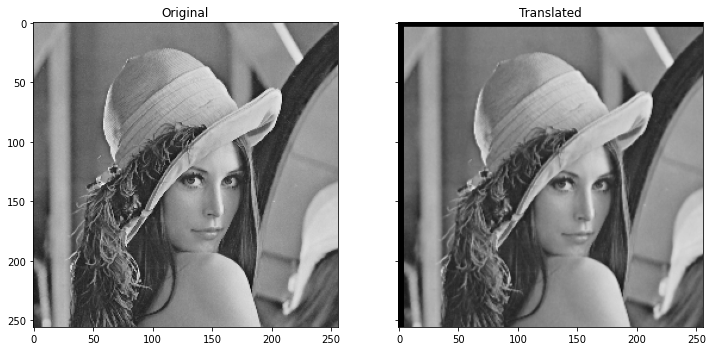

In [23]:
lena = imageio.imread('./lena.png', format='PNG')
# Call the `translate` function above with the right parameters.
# <---
lena_translated = translate(lena,3.3,4.75)
# --->
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 25))

ax1.imshow(lena, cmap=plt.cm.gray, vmin=0, vmax=255)
ax1.set_title('Original')

ax2.imshow(lena_translated, cmap=plt.cm.gray, vmin=0, vmax=255)
ax2.set_title('Translated')

plt.show()

### 2. Rotate `pisa_rotate.png` about the image centre, so as to straighten the Pisa tower.

In [24]:
def rotate(source_image, theta):
    """
    Rotates the `source_image` by `theta` in counter clockwise direction.
    
    
    Args:
        source_image (np.array): The source image
        theta (float): Angle of rotation (in degrees)
        
    Returns:
        np.array: Rotated image
    """
    theta *= np.pi/ 180
    num_rows, num_cols = image_size(source_image)
    
    # Create a variable called `rotation` which holds a 3 x 3
    # numpy array that corresponds to rotation by `theta` 
    # Note that this matrix should be T-S,
    # so it would be the inverse of what you might think of for
    # an S-T rotation matrix.
    
    # <---
    rotation = np.array([[np.cos(theta), np.sin(theta), 0], [-np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
    # --->
    
    # We pre and post multiply by some translation matrices
    # because we want the rotation to be about the center, not
    # the top-left of the image which is the origin in our co-ordinate system
    transformation = np.array([[1, 0, num_rows / 2],
                               [0, 1, num_cols / 2],
                               [0, 0, 1]]) @ \
                     rotation @ \
                     np.array([[1, 0, -num_rows / 2],
                               [0, 1, -num_cols / 2],
                               [0, 0, 1]])
    return transform(source_image, transformation)

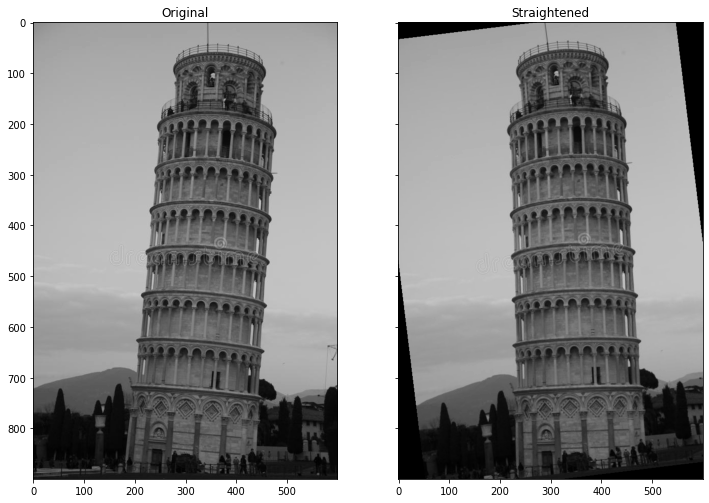

In [27]:
pisa = imageio.imread('./pisa.jpg', format='JPG')

# Call the `rotate` function above with the right parameters.
# <---
pisa_rotated = rotate(pisa,7)
# --->
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 25))

ax1.imshow(pisa, cmap=plt.cm.gray, vmin=0, vmax=255)
ax1.set_title('Original')

ax2.imshow(pisa_rotated, cmap=plt.cm.gray, vmin=0, vmax=255)
ax2.set_title('Straightened')

plt.show()

### 3. Scale `cells_scale.png` by 1.8 and 0.3 factors.

In [ ]:
def scale(source_image, factor):
    """
    Scales the `source_image` by `factor` in both dimensions.
    
    
    Args:
        source_image (np.array): The source image
        factor (float): Scaling factor.
        
    Returns:
        np.array: Scaled image
    """
    
    # Create a variable called `scaling` which holds a 3 x 3
    # numpy array that corresponds to scaling by factor 
    # Note that this matrix should be T-S,
    # so it would be the inverse of what you might think of for
    # an S-T scaling matrix.
    
    # <---
    scaling =
    # --->
    
    return transform(source_image, scaling)

SyntaxError: ignored

In [ ]:
cells_scale_str = b'iVBORw0KGgoAAAANSUhEUgAAATsAAADwCAAAAABa75zYAAAAB3RJTUUH5AYIERgF5GCL6gAAIABJREFUeJxMumeQJWd2HXg/kz5fPlvvvXrlq7qqurraog2AxnQDGJgxmBlyDIekaLUSl6S4sstYowhpV+v0Y3e5uwyZoMgIiqREJ45oxmAGM8AMBkDDNhrtu8tXvXr1vE+fn9kfjSH1ZWRERv48ce537z3noDJRfBGLwp6WA97SGcOKFAAIhCDlBbGPlwIF8XwLcuJ8slFucOh9ZrPqPZRpjY2HWtmxNM3AeqbxBsRGLBTcSvUK5w/OhEFxZ/v846xAPm18+ueH/+onfpb9Re+z6esfPPnal+pqK1GG30kUO4wRAhCcCyGRiDgypprHSwc5mLnyww+LTuvEHriz0E+mhzQSX0z9cW7Kp+ryh1/4f771kj8eH5ZSE35FVsoR4X+6O3sKe9yOnIGl5javaTJbRCNtIhRaTm7vcRJo5fva5ztvlMyxr6oCpJRSShBCCJBSEp+sdRV9uJBjPAVI6I2k7Oam79IVDxrv5eZvqn4Q61ZXoZBwwMASSdJeSCHUP+u2XkjdIenERjHHWDCBVR4jxHLF0KVK1M/oWjHouo6YTiJjd7aWyDiIhZVlkiXReOiWh0OuAmcdm2nPzaiFqcqB+O8vlC84Wxnt/zz13GP532i82Tr1n/fIwsuTZVEsKCc69YzXyTOEQEoARqiU1rFTAKs395bFw63bE86uXrOGDHwHIlX1wtLKa72pp/rzR2+19G2+FfWVDLQpZREXSBGbTiYY0j4aUk9GdlNhEbEN/1AP1TxUu5pQ4liq3j2iiEhSLOHjI6WUgAAkKWTd2IS8WeNpixK9TXVyFm6t33hncrJ3cymp6lwqbYf7iUYirhIEJKNgpXAy0U88Vv4oTLwrHQmYYoSIYDhbUlw+myU5izvLJB7vd5JF4zXlU6XXM1NVlDDApsNlEsW+FxXiJiCRCNXs4WnXSfaq9j+qhP/Hb75qib96uv/K7jK9nvvbL7PnC5WVzH7gHUSi9pAodiKkBCkF6DJJOPe7zacG8KuZurCnnPrU002/pE1iooeDhmr4dtsfZdNu1x7pX6gdZkKkp9MQKjqO2IR5Q51ucN3VeQpQyriTYOBKoZTvzs8EO9VIRTaKdOhhXSaCEAB4hJ4EKQEhACSoO0gmCB41aEsEjR6ek81eo7x5FF4fHG/ezTSpAOTr3JKj0NDcJBHEYEFffnp+qmv0iksT69Y90FTgSNMToRWywVFjshALppzqRgZPZGr8HVN/+0Z2j3cwgBRYo4gBRVgdQ4MmESNiiNfCUaYnrJ98959dL60I5+Gmwl7/oD63RN45+fjvajfSjW+8fO3Oe6X5o2CIeohxxpkQMuFERYGr1zawu5vChnZP+7nBVuC+eKF25BqfmhYwbAktKk48OCP2tz6TuutJZ0oDxO3IB8gmN4L5poUpNX2bTLdvawYa9QIBVnL7h1VqCgixUKVXBCEVBSEk0V8TDyGMEA6jMYNUPz6wrbvI6/Yz7MP+9rgcNs81ouLioKFGWHBnlHh4diIYCE13SJkvHI/MXrfY76w6ztSHIQEQApEYq8gb9IaU9LYO+rh4eyzaAUt/zyfzcDNb3wIQLImxyYVUdAzEF03EuEQsIWfiXKpsZt//He9wU1Vu+Mor8u/+c6V0dS1ttNJe4+tvDqXliwvjHwpVKIkQQggJEVGASd30xhfRrVURiSlmxt9lZfaL/Ved0P/lqWtB+WRTXRz+oL78g7f8Q/Yw0aN8MECK1ujaJhnfcDWTcpGIbiobbI5NwQR3G/tH2y1tgrqBNlAkSgmBgChY/Ag5BACAEAKQiIIhWIcFk7wz1a/0JuB2jM8N+9uWGh5mM9sEIYaU0FleSZfXK9AHTNCo+OTyPDTOovrDRnA0qUHAKUWSI8wCP5Gr7n7Xlfjgw+pWNSkvH3WX6jdYl1EOnAlpZMYSCElClhp1GSaCKZBksXE0WUzGV/Uwt6ENwukvreXLq5fGqztf+NLc2slPnuWAkuLjy9tc6pgqhFJCKSGSScnCM8+6HzmZj9TPJe3ezpJeM/jX76dYP67f09ELR0gbG+XuSsN0PwAHtQwTI5fmdK6k+nfFeCHEPjArX3r/QOUMGQYBElomBGOU9oXtjRVNAqZYSgkYEEKAAH2MIFcJEQlKElPWnOzOQsO1+yFcbj7IuxjnkZb0LMGVwcRs6KvEFcUjxInJ6q5kcee9u8srJHfULgauwCCAMgZIV/hEf0zFRP4jVUU0m9/aEK2IksiOMZZAACuaAiCZUEiVMQWECBRWVIJaeLBc6X7myUsrf/fU1X/iHa/94fTNX3vm/3a++frz150njv/al3/hosN2h+nMwKAYIUAgpSSWBbGI3rUvBc7EYE/JhVG/6NejhfH84zs12+55RzqKPx2+9njnVixVL5CpUox9Ome4trVTw4CEglQjjXt3QyQJERHDKugyxgrEE7lylkTCwAQJwEiQR6ChH7GP0xBHWFEYdhMS+LE3aEWqmlSZOdB1xzNzNQkI+LSXTjGwRTPv2MQ5d+J04UEbPe96g2YGIBz5nMUCc04oAGfuGPQkt7jBgVnpwjWkAfUg0zcFkhjHSbSoCiaRnm7UTImZwEiinIuWHHiPOdX5u2HxNyfQ/1i//I3v/ww666TP/NbtZ/WgVvFemRs+fC9hbjoWjCVJkoCq8CAC1avDwrGtTo5VUGfJZ5ZFsdM6e/q1SFjnb7ay6x/o1zeP0oNEJRyRZl4NHPC72pR302e53RRJK86wdU2YnCHJiYYSEjAdkvkXl6bmnzod9AxCpMAK5uRvqlYCACAlcpAax0YAtuunesyisT2xRwtuhmJiqBm3S0hUtgkCqgCoPpdETS/nr18KO9O1rDz0xquZA3AtwpEeKIgjpjKFC5k+8lWGhNfAEcKS4JhKCQgEksy30jRVhr065UgCyBiAT9rD0THy9qn3X3+i3/ulBsrqX3SJtnSn0D2d8VcOf/vKN5p0C6oHQuGKH2tzx6cdk3VzCUZYcifu3ddFL+TGhr4gxjQnarDS3othSqvOpU/dPHz85cbUyBcBogFH0+p0wXPjgweeZ7Kk1zns3d9rIS3BHCWRIgMNMS3wnihGiX+0lXqqdUQRSEBCgIYDplIR64QAaIJyCAFhBAxJnhoTSWLBNK/AQRCNagr1Yh5kK9FEDCRWUzRoV0n2wfWDk71e96gzmyXFXr8P/VD6hSHovhqmAWIwhYj6UmIioxAMjhAChDAHQAgR4nlMJINq3SAYeJywHMTCsf2jYN4abs3mXmm4/2bwqcEfHT/1/h+e/NYbt754tvH1qNfYuFqF2zWMUN0sL08qKDMjYg4YkDRZki6po6FetfoXstugHY4MGu/lMqbGsKY9qD68cOHN7RSSEiHOsIziwBv2Wn3pJKEVAYKA6JqPGZgRTSInFJE0KhUWxiUnbGTmGz7GAAiQNowzxnCEDDXgWhxZsQCMkRRCiwlf40yDWNNN4VGkmhpiUXp0pBFZioCmKKc6jBSbaOnITtXl6ZWdg4No1g2IHjPJND9ROeFxxKhQQiJkGnAiVcnlI+gQFoAAYYT1qN/t9hKdCQmIUjpOgA8RFR4w89hUsB1fqY31zd33pruHn1psjv9o/0SzsR4Pg9fqDzEZqMmcg0fdkTcqRW1FABFRiEC06RQ/jchytZDcyqecXNDzc17R6G5Z1yaG9fUgQF1NAABwt9YaRJEvjFDlPMUciXQjpCLNjSBxDC4E1kWyaCSRhvR8a3Qu3McYgQQIDNEampbwwMARUTkgTLDggms24UXeW1aHzpBaiaIaGqapbM47sFA8rw8BkkRRYYyAED+evjR3f7cWPzV7UO0e61WjEbFHGRabgZ2ICc1PwIo0TyKBLZoIAggAMHrU2AFUJikFRAmIJGGCg5ZCIS0XU5GbMa8lF1Kz/vD0YR6d79aOHjs8G9xQXuysdm89fqGzb1o+UxYp50ZGl6ps0hgThogVxlH5xO7x8GHPpcQpe/bqvqIaZsqNR8k9a+rtB2OOsgEIAVRERAgWBqDqI4PHIXW56bEc6YeBoY6p6qeHthjP8zjRR3ISV0v6fQQAUnDNTSrnzizO4Y5ihrrpawhjyQRmxqXcjOfEWccqNyxL5U7eFDEXvNHVWJRJCSkUQ+FxOmiTvPPSXKY5XJ3a7/f4ArWQ74aaPqKEkzi92J8u9+jjE428C5TImCsmRxgBIIQwwgghHBJd14hMCGBCMUZ6EHIIk5GqNH2xmcsc3n9mVrvXMKYf+OaF9Wv+FZa/UNuu5Y7eHnDJ2eIIqwQhhEPLFz6liYJQbHI8Pkz9UDDXjmcDNlzoYaOOHmzMnhhHd3QjTgCPgQCXhCBTJ4whIqlvxBrlmXBZ98KIP3PwY9ClPo1pKMR6MIbQwJ4Rk+xdIQDJhLVPvnDSJJnJ4+Mhs4hnIQDggurYTrfCwXTeMzLDNsFpSkXEsEprDV1lMjFVLjXqj8VK54goPr51GzdNpa3HcbFZn5ioIxJRj5s+FFfuDWer6DTUs/akH1IhFYkIRh8fjDHGlMo4oaoSI4yR5JwmoGDEosDyoZydqHfUjVvG+kRmJv7E3B9c/ZylK785UGaeq38jXKIhj+dtHbOYIxI5aBxTEDEwpshx39mmC7RwbWV7p3joB8Ppw/1B1qdqYTRgY1sBKghwgTAKEBLEUCGwklgBNyUuTN1iT0zP3nnmo+xSvdh+vsqNxXCUigzWIxRNfyglklzAheN6fawOb6fntF1V62QSIaWQqnVyiUlZSOtx2ul55hCVMcOWTaLuWPMC4cockYJHxmR40CZK0BjNPj7ym8ma1Rw/HPaimmBMn+xrkXkR/PSEsHRuo6mJXb6UQ5CohGCMMJYIgZRCcKCaAlxoiEUhE8ApcCESYRgTujcUhh0mFU+stLy11kN+5/a+ud1pP8Zfe9+nfpsaSh57owghAElEQ0JMhC4UhqUuGDrh78YJ3u5lD2v+6iiVLm7flfGOT8H22gpICQASCEUIZBKhFJus40o9dk68W/5q7v3e7F6+pJwk5+8qiQauqfiJEVopeQcI4QnSL/ebXPST0vZUpdazOEghEWdEs3WvUBSNllJxUmv+0VhDloGGexuCJ9wwmG9pFOuGpt9oRsSMC+Pl94aZY/dbkVpsREGfqoyET9Q5V79UffpTq5fOW8vPskptJ3M5PcaGIBghwFgCSM7ixBCAIQEFuMCpytJyZpLECuVo3EzrgXfIpmpqr1K97r+/RcewfWR1B6VU/bVbsUhFVO/zLGArq8ZBrAXsEItI49KjjMQ0TAd6b2R0Mtmj414Kv3H43IMb2WG9qgtTdqmFGZeIgBCIMYSBaKFIfXLn3K806sZPX+vnVyv5F0806uunzPbtzCjOuEz3lWxnuvRRkygoYYqZ82JqW9KdaKRlVTEiKgFYjMjMsMGn6sZ8zznqp+96Wqc3qO40Is1z9IUzM5lwD1Fsib3bPaGT0OirByNsvlbOdILBmKmc0qdrEJWPnvvEW888g9TppfT7F9u9l5a75f4UcrHGVRblXTWJldJsMSVd1eBgccDIOpuSHRjhFAWIVd4aGbPTksasnDRYBSVL29qxcmW0kGre72BFRIQGXJdUJSFTFc4Uv4UiVQQFl9JAk5oLAx/i1PJ9nQw7LBEQdkI1NjhmUkVSIoSkRJhSRjQvUIOYrReWh1Pl1ovpf/irNx77x2fr/81LMziVfFC/lHoqWEkSZIariw/uqkL3FTQ6zhFDyEyHfWFN7g00JciMaJDkHsuOL3kb/Mmz7dC2YFYfGsAVgyCytjBvJ0n6JN4YNYZ3hlQhiHy6d/bwwkDvMg37oR+muSHw8dSo9JWffPbYHs+k427wWnXtYrFwYcYdZzY852C2PqU1rWF6YWmmMrOQK2OfmiC0AC0ZYy+FOWCERUQRjvvjwIssPSGFHMnMQ2+Ckb7Xe7gxQhhRkEhyKaYDlhAXafGw7kkaJeACQ4UhxERLJJKqP+BixFAo+DBWkdATkCABJPp4oyJchiiXb51BoVsU2z//6/n+1HCt0nvv7iml/Bu/9DNR7YUTIj+xsZiylmduvm0jQWIsWUlFAZfSzGbHav67edIkPOLEsanvj2N7fNStLZ0aRuq4D0CIkLozCUGChUQzbS8NIhMTBOSZK+mjp5LtNOG+i9WEh1L9ojn5956bQy3v3LNpI1tMBxePpZby9PFlaF2n+rmtmQHXdShPprjvBfmJuC80gWOtUO5TCSxkgKgMESGxCBHjKdHy0XCvuluCe97UZqNRC6nCmc44IMFZmE51mAk7/Z6rKJXZymqOzPBAsyQDlKExHkqaJJQINY6oJgSR8EhuQwgAgYR4dqwS+ulR8r+Z9NPng2Wr/ZePh/WzohKp7WPOmn3iHxjb8Zn/2Awwb7y3oUrKICHAnIIeY8UPoSnLDzoCS+LpIhkpZWbGzqdwu26F4igVP2zrmCAGdp5HAcecoaLdSDhWYx1j8umS/9OToOfrqpkkWOBUyAAyIr/tz7wDlabRU7R0aa0+0ZdN9Dnt6CevDBuJysEt6hAzkYRgqKIPiMT6tNLRtRAEQoCZRwAkOErY7vYSjYKZxs4BwR/VR7FUNRYhzARGABAEvhYNWnxsL10slhXBTTnJM6vFslDdkFuU2YpQFMBWQgwkkKAYY/TxnAQAEPZzAzY3rQ+rL37xgZ2/Ybzfyp4ddCYmznyNFAqz26mRlz3/vVfofrBbT+xCgjkILBOikxEzBUc6KN8eeKpweeTbYZBRJ9WqsrV0NhiKYAYaZgJIcmQ6fUUFwQSwpaRqEGZgQOR/JwdJmF4YSj9GuirVYWnk5MKL3lvj8HpzeRDxbbbx/XNKVCurQbCvTb77F9pxyWIjhxKuWKaOUTazL7RY96dwnKhCpRoCFI81hEGxaWiwgPu1VkseVTux75oJRpLHYDHABCRgHg5Zk8HchUo2zUyCYzQj1TPCL6TP0IHIBKrCQAdGEq4QhlVBEEIIAZIAgKSUWa2rqrxcf4K+qT0Wci6nnoHB9w6W91qvaLO7U07yO9//5OmVzM7f+V9XemYwyglAhAjGnVQcSIaxr77VufLJuf9qwXw8vUEuCzcZxF1vefn23Gwv9OtjKhECrGkoo8aCylgY+UNVIDUBSaatieFdN6iIZqAToU91zF/78sVMeHS6PD7F8nii0Ga3xkWka71S6ff+vNTv4qdPXCOBklEISEBID6m+iahH+JwXq3rAEZagCg8TLMC0qG6qqqEpTor7qTDUGSYCKAYsCUFCSMQ0DnymUuaGHvdGXpyxIJ/zs6Z0i6lULyaKYEQFULiigaD0r+VeAIRAgvTGhg9n8ufXZ85+yzuRPH/g+hWkLNrl3Fxx3mKD/y/8lTntveMz6+KND5QpZaAjTEBKpmc1IiMRdjr8xCcEtg0dpaDeHj+FlMshffBerkRBNQYdXQICpFANu2OsAedN+8iLFJ8AJsoPwy8xJ6gFgQU9MbmsvjjanOfSyqCgohtShjjAl4Rnl5RhiuqPfzF3f+UvmilJLUXBmOpaApxvEy4YLfEww1gCCBSdjzBCnGRscFXMiKYpujpIZqOIg4KIRiUnCKQAkFpoHT+pW1lpi91uPDG3sNDKmu/NuDrzeuXOsCARoUhRsaJiTOFj2iGEHhk0EuhVY0bPLpGJHvMYlXsv7k9m+Ppg8PK6ZnWS1b546tSw+sTEgPzG9RIbU11KAUyQpBVECubSdbc+99zu9tM3Plq/kf8VcdNQ3JzdsXS9175vR+NejARIzqkWB67AXGj9YrCNDFsLAZHjJx7c3PGXiOg0Os7ZXPvSc9mvbZycTJrrzz+QGdTgOZgtSrX2RiHTv2dM44vKwyVjPxuUqeQCAUM5lBySWMNuajIR3QmsUqxoftuSjOtp6GONYJUSLbOVMho4JYUGsZCgCCkEYCRjZVlbsayjQs7Rzpy5sLZtsP787LLXvDw/OEnbDBMFuKpxEAwrUmiAMcYYIQEISSml+nzl9MrVSkQ2osfOqht3Et3t9MlSIxQnd3Z2Tc1gqlm48xtrl9+uh8MkkkgwEQsa80GXx+64Ub9Mg3u0MpMUj1/4KPtjoygo3qGF6QgXRf7G3bHGhRQxU4yYUwOGLN3+auPezKy9+IAL8oZTU/D4IHCKvk8/08pe4Tszn21s4963jaZgd84M0/KgpR/9VX7ynbvfyi2TnaD53Bu7RphGCVNxwtPDie4h1iJgOJ/pRUgFBpoYjHSuiCSbjVVMNELt9MDloKBQx0AUJEGGVhKrJMQnn22Wk+3JQuFYPmVmM688sJ8g8/t320+yb00liw8EQRKI5AQwQQJhgRCAFEIQnnCMpJhxHx4cosqCOlfEqn8k06cG/nWh8uMozNIPZGNPf7AO3xY/p3/ubuOZNa1LMcEUcaJacavd6cWfydYvesXJzhIMlH+dT7Xvd5bkcMFrl9ObSblBRUAQxsowpQeJ/PyNzOH42euHVnGiR9kp0vlw/5nH38DuzWATjfsz+elxrBQqqeujgz7JJDOnL3Y6U3Fnwszqk235Fd36wXvzv39qhIZR2oqYSsW4CLtjXQSqjCItp466sZZiraEqQEExmE5MRIItXVYjwiURKoCUCCPQEkRZIsWlcDaC4xU4fvPVk/j6OXK6q38rudLaXvVGxza1nZoNgAAh9PEK9sjZAoCxalIpkijKoqlCe59S27u9H6izfFTcqttq9OG1dN94IouePpPsN85+Svm6sfvU5xdvDfAj6CWTSKpS5IK5cWZtFN14/Y21iQOr8q7ogt71YVfTdrZbgU2cOBIhTbhnDMLK/Lvx08nYe35ZQTOLT5BWx+sND53T9drSc5PNhp9pZ6z791TiLU2L8cC7P+FK3dStit0SJ1YUtDhx6erX5HArG6UUTkgSTVZ2HyAqCVf5wFctvZi1WKsRKkIC5iFKmSlTNc2416RqgglTMEhASEoemaqvrZ9IDCAz0+bXJ8X2aua3q1Mr/2F+6feWX0zL8oSama0PqAQJCIH4EXIfG9JqklCUKNkcWfyEw0Wn+ybMpE9Udsf3KcosTZY61Vmj798alD58vc5S5BYk/aPgT66rUgrBhZRSEKYIsRI4m7L7B6PMyV0zXbYXT1PjPlNFVrwtAlfR43GY6DTMSm91Aprnp4797dOj079VwE98+izvkK+uDbf37ZGycHDn+uhLX5h28n1frbZnFxJFivG9o/291LCrjKVlIUP0zSRjeLXvnps6JFGcnsmlJpzRddeJkMoQEuNuRH2/tdtBCgPBkBr7YYqouhI2j7BCEoxDIiQCEBIQwhG35yrG5GBC7zhodXre/sTZh69cXlXXniL/9szeXeVOxb3TpVLC3zwgH/FOgop4kiSRt07KZi+9QPihY3Sc7MgqZi6HDxtKno5n7P5Rr9zfPPvSd/+s8FL+cun2nzvwsaUJCkcRcHrqmdHe48eyhWLXSS/lMnsfOafvHlC3k3QixjUc2oiSkJ+q1M6uh5dTYWFuwTrW/O2Lc3q/F5GzmY3j52n4sL8Y0rbI/MBpK+x9NvGgR1g/yFlscmPlC6yb65myTCzDZ1amc1BKj7eMJMQ6D5K9zUbeDGmsxEKjfqfVbHc8rEOEMQIi4yDqebHb6sa6kAngmMcSJBcIY+yLxUWT6F5p6mHVvPz1aO53v/nsqbHT3v5aHn3zyvCV+WHvwb4uP7YBpXxk4z9CD2TfoFH2iSsnixeWQiR8zXvqlN/e2MzWmVitjHt8+uzI5ZmJzObqujnMXbJkeLMxTw4LAQIhpQDEZSKFOVvNn0q7mfTa4d9aeOX35yvfaz2GGt24y2wpGZahSZKQmqcnRjdPPfdSqXLirfhY21jr2sODc0+TeLs9dI482ewOp048r7R7M4fNxQU0+YKyu5zadyqVxHtSu1+m9du3Jks1Y2n/rffd83f2T9Y13u+0atXWyEp5QosxloJolBtSSalhooCiygRrNBqP/dFQ2jzCCbNJSBEICRj7SKTXprNTWqqYY8VjvVdm/B9mzO5j2vVa66JZrD5L0ubU/P2eDo8kagF/TTwppZSWjGO354HvUpEpTWQ0/6Cd9OKlkwebrwIocaekHQWTkXpxjy/tjo/b1r/6aNZpLyptDEIIIRlwLCGj3Etr//n65r699oO/OnymkL6IixrfcxyICZGKmvg+EzQyivMv7eTiSc/7MFyebPong3p2HpMvKcXWyGdLrlG4o19wwc2BEw+U419QNyM0kWqN5Ps3mnvRpGk1HCUpqsrvd1+qdde0TSoFFoIg6kS+CphTzBgxrERizJhiiYTQGJtIQVJwUJQYpxM2lerNKFJgiiSw1EIGrFJC99+cSJLRg+PLZ7707r+d4jXzs833LrEPlqlwNx46Qn4cWPqYdR+/IAKcpsNW62xtdDDEvOrfqpFcBgcD1wjcdrZ2Y4/x4kLtQdF6KKazHXEgv/hk8I0S3haccymBU58mZNLNZtPREJHK3q7eebLxfeUzte3SIOKBpkSJRBpyjhEWZU89qT9evPaD02Q1lx2brQX3j57TGyTv76yYPgBbmp191k7bx+OuHcvOB2/cMVRPP6KJqHhKaTxpopNm5P/e6+TEysX7+5OjfpJYdhzrKsORro9VkUgNByMfdCVBBgnUEWiCUB8oxVSFCJvFMFx0Dk/iWBAimJYULk2aebt6qHzrsduv/ZPN78+xd+vq/PRosP5a9dD+8M7byL+mMSmklEIIDH/TaAEkICsZ2RdP56eO5boVea/qfuqsR4wRD7PR+lj9PA4spV1DsD+0Eu+OXf1/x1cWRt9ms/UNxriQgEAZ4lCd7c8S5+Lo6rnp5ObxyieM79an377zVPZwkJOI29SX7NjVyeLKuSnIh4P4Bac+t3R72l5KdgInPSaZLO4KSMauVvIjye2eC4HLTNeFXuzXUubIovlc/fad+Ye1ifw7ofWUELnGNa/WwyiKVEMkFBERI4648KKJMkiSYMSRiLHyqDiRlBjXKZM1AAAgAElEQVSzCHy4OMcLJ8U8m8QNFcfyqixxdM27WFi9Ut2dTteffFkZ6w19aWUYtS6t9dj5xa0mUTgIKRHGP2oZH7NQyjimbjNVimJvfThOhyVyXtucPxMm2V8+7GPeL+SM9n5ULOFcJSXfWUo9sabHav+jd3zHNYmrdURfVTxjdS3uva5c7f6g9vzz6eN7z86XZhYaNz/RrhpUMHVsJKJn55xP9dE7RoovCcVp7r3r0Q/YxclJ85DMzkfNldRtFJFUo57K3Lo3jHM8U5sw00P6yWfkRqFFSNfDWgZuf5guFieogVL56ltHIAGBFBIwQlJKCMbpx86Up07fF9LQZRxSzLyIEIwSavGBOmOIdBl3tRNks1gfl0comi9pc1ZTKjuN3vb8zfaFoj373tUL7Nvo1ualtbYLUdLeGeEEP4rHfQybkI/SehKEpNnc1LH8STWG6uVwRRzcuknsnx7dOmwdhfa1rNs19exipMnbh/MnK45pNq/VnlO+r203rXAg2ZKZc0eqwYYO9BuT/wE3Xim7/8t723TpHTP91unBFpJD200Ns4qfmJPzER3ldTPZv86ykf1s9CDsZz0rJhe/k57cDpIj1to1zhuDtjXkTnr6UEPU1V962hvZRopZU6nCkR67WTMlFWkXP/xmYqmUfOy2IJACJKydzPIghpVOm4ph6nzl2Hye+jzNFRQyVUlWTqUPsieC62ap0imEDS1eny4lrd3i0vidunWmsfpu8+2VF+pvnUiO1bZT3lvJVNTY6WD6o+vuY8aBRI9QBA4RmTo1PboPMZhJ2IkHzbS9/ed3DHQn/OqEp2Q+Xw2yY78k7rj0EOv42Xfe/vLE1Lb/E+vbnjHzhUL5WB57Mk3T76GTy3lG+87xZ8fu9f3N/sXzmjY+1GwEvVxpqvTYhUl1qJwpdlqt5Agz2+7lT5VKfJzyiDyMwkZrQFg+UY9hJOz4qnWznh7xkI2H2+/3ORORTsYy52WmxEAfqmdk5v0/cQQLIy4lVTkCIaQA+0yu1hLJOJu3W+HiNJFUz5muR7EqI6mywYGieBMoLIuyPXDaJBdWpvm9diA/erIQVbS8NajGR+HtI292UJtQOkc8PzhoCA0Qf4SeAPko7fWocEHqUk31Nz21vZAj8LDX7RQKZZHsp/SiPXp+8mYNnqz6igM+68+btxpkk1zRxR9WJ5R332jTtcvhtloTxtDI71yx1qw3L7H9Z07+iycz2eN6OJqdftgoVQMyItoZYzx7qv+a8jh282VzlL64Thr+9nRpe+fVaatPuvlhWzKuJYVPXBYPReB/eaKquMF0HFnjextHvqdJgJ6XKnTD9LQR3r17mz5x4+UiV6TEGAkGIKUQEp3BLT9lEnOYz3fhmBXiICD5vOgYCTbAV8qZC3ODcS19buNtPQxkvMfsbBXKRRh9lD4/fFvvb5gzxTt25p5ZbS2FeyC9RoupkCD5o6CXBEAII/Ex71yqpqdWK35Gl0cbC/yL/x00Wdh76vDHP//tzrU3NXnrNTJufKUwVEzTOmEs2BuZYxu1G/Pj/W1zweruhdCJwHOWSw3u7my5n1xYxAtXq++u/nz6ROrfKZ3pXEtmOqjtKGdHxOre2y7ceIgf1/dbq4+JdNSXA+BpnWgRV2NIu1rvsDu+75ZE98P+nYp914w1LIr5eOqfWjuTJCkOtaP2+kRnLy4P3vHlFhMSAcIyIQBSSISOh55EcYKUhDLVRgWa0mJUSQ0YkgnJThan7z+Y/aTfuLOYE+myr3VE2aibGw+9tetCvo4dNl24P2VsQ3mpgvJ6nHceDiKqc4YxwviR5gQIEAL+Me+Y5ndrbkbNU283IrHS+qg+GB9PjV67yaYyPeRMMWu8RVv3p08cPrgoWa71x93yZfz2vXuRMuvtaf7Y7NXcHp8e3tguPpHst79xGEXBqavfnM5m3iyYd5WHY676Ye74crAwpazN1Pr9w9qR2j3yqvs7TXvKqKdnScYHRRO+Gjus99gJyaHXjUflGMfETyhJ6stf3n2HOPkOshrNdCKyUzPey4OfPH04UEmSKLoiEAJAGGugsWFC2cjMDuhs0u8lqtvSHFbX5BgVcyhaKx7t9M9x9eLNpraJMm09r2YjeyGMxGwUsJNBreFk+RKuNup9x4w2RglRpPxRshAk+lG7eEQ7WejLJ85Y6dk7Cg3WtfTD930IL/7L6uY8UpTp6jOzO8sBNdrcHU+7+9qdHwTZSVxZWvpOtn0406gVWkya/TjP6/uFob6or959uzw64Ge0f/n66z9kxfGqmNuKootnPjXpLMSOCV6SzKuFylqx9nDLSU85vJRFISFqmA9DQxANHZ8roATTQU6USNtU8omiDhLl4Vvfj6rzP7Ux7KOy3VWtHLJXxvfLl+zVIg8lcMAAABgf46ohsSodVwRUGRAjNMyAav4e1tVohLNS7faAru/fDfwu0H0+poVBs5S/z2d7mZm085GhqbGb3e10m05rtz1qICA8BsoeISYkeWSlix8tZUOFdnajPCSpSowu7HmlwFGar2963SAX95WxiEENcU7ne2OrIBvDT2ra+pmt5qjFQ1zSuRUDEWEnTsv54uTUy72/ldmyrXX5Z/KcZVTQLjqeuRuTQzYU1YdOcLN6V14azK7t7bbUbEVOxgptniptHBAdh4gyhLCojLslG7cq8d6ZVW2UFF0a2WkjiWXO1y5890Hl0x85i3uJncITf3BtEM+mTz21fNvAFCGMQIoVsxvPKcEMUbQDKzIjxnOBQGm/rSaa6y7MHoyChR+7s+FZ/QvTD0/k73OGJ4ciAsTmjvaN9tF+LluNk7rAdqnrBa5IB0IVCkmEHiGaOKHuAuYKAwlISgmIxHB6wW5PFUZOv7c1Js5Q/Zkb76YGL0zVBp9ef5dxd3qYeu7tlyo9uExKdpGSOHj1Xz/x9OJmg2gGqNQfdBKG1kSrn2of1Z6xql9+s/PlNnYOrpRep7VXp4dJOFQuzHGtO8pU/Nv+SuU9Hi/76SV+OE4/qOCeTnQhEQJA8fPuUJ1SO4SPX/xso9OBSHczIm45tkySnj9u+59E0dGxk+rGOrt3KTdqhg12ev11piIEUnChQ78FmghGBXfnGO8XQLfGPKNut3UZG5U8h8su3Ral5XN3IN1ojF1I+BLHfeIc1EcNWupNBjVfDZKs2Rv0mNCQTx0POFMxZppHxsjLEIk9Z0xBSiEBsBqn9N6L6ka9nzRJBgIc9bZPCvZrxuv9v/+JP0l3n/+l78YHh74dvXLh9K28v0xav33ppZ/6j9/rkFRnX3Y7o4UXnjylXht4NZgcuzfOzmNnefi9peWfS7wTL7xXLbVG6tXo7JIyp6Wmvf4Mfue60b985nbQ/9nBuMdfETxLTAkYAHDSPOzhZzZjD7H0+J2WpxyfGRi+W4kY5njcYcOYk6/3fXlttfegttJ2GeaH4VX74SPpGyTL5cGLMUrzjZ1jSjvsWel+X1W6I0W4mumxUtR84IV9GW41PBGALkI1mqrKWGQjZyLihOKAGESLNpQhT8VMqMpYsSiOOUmSDGDDcMHXwiTNEZISEA6lyCaD2evJtLt2nug/1wwm360gMfh3e9D99u8b0d5BqzpWAxJ/WNzfTUsXJunpxd7ExAEgQbVgrPwP/+3nX/rqTz+3XUtdydwxx9T5vc705OqlqT/9/tzy7ZE3HaCLZ8cL6KBKU81gbhLqsZncqfb6SaeZsH4lxYCYQiIkATHBVI8rh1S1t24PA7v167l7/fwwKYSaTidsP23j60zOtD7oaLH57wNQdpQy33/6dhchkBihGuSySaCl07cPfT2TGagsBsts3UozLNCgNz3azHsX55vx7RMCLcmbA5KojdwoLTqWL1K9g8hXYojG7AiUEAQgx/97737586/Hjrbyi2+efO6BdDMGaJbCMAYAhLGqZkv+5Jhn2fyF+N5OrXlITvYWP3OUXnisYaagaI+qk72l9DzLF8tUzOrffjm7Xvmr3mWzJvuZ4uHsTyzvHLZ2M6e+9B54o+Wd/PobmLR0vP2ne+Nx688np9l4iB7Ola9HTbfqv3D8tY6ZCzJRe9q+3WD+j+1N6DEjhgQMUiKigp2x6dYE4lJPSyVX/vaNtnPpWF3EGHRVIM2sTk4/E585flsWzzenfEDTM9fXkwcES4lAIo85+YmsdndTp2Nj2mFgzzqsF1GmEOKLY3QhH8T6IDlz7nBE46OU64xhMBGnnHroBg54VtiDYOhL0zMTYUfRmRH5ZBA0lfFj1F0/3CUWbtvRAGsCHo0r4AWNDnhnUF9598ZYjPTwLxd+a3p76DtuThWNv1+6d0a/++x//bX6V3oG+2hida/klYf//J37bk3z3IH7xMpWNesPtGqz9MfN4//Tr/+DT3zLrwTtK+8fzSpr7Q0z59a6ne7ZDGQISpXk5t5UojrwizCOl1KM8cIupDLEEBIhIQD7Iv1UsVrQp+p6Cmzf++CglNE+F7+iWCk5HCypQ5mH7HRvcfx/3bhwVJtVs0Yq6SraLYUwBoJTv1PvuvV7e0gLWTCiBV3ld29UlQRLDhIEyrttdtPsadHIC+1oJJWYJtEAKaDHdmqoMOn5UgDmv7zla35F/eT2QhjPvA/ZirfKh9UvnLybldmVQ52jR4MyJzTRBpPTfr5St1W81nO23uQHu9r8YPsh0qNX79jGrWFn0N9S2LAjEiv9+M7rn/j8v2ctK5ZBMDm9RWg4IiWnuPXyb3/hzs49+Rnjh1a7dPXJ4eQTGlnZfnf9ojh2RioiWn1s8FY9N14/f6P/C7mPZBzPwKYzLbpdYgiJgEtIcsGT5IfKVHapGzAghJpp1kvNvNk0nixUI/RUqpmT03eU6M+U2+Z7reyhU6Xridd39ykkHCGpW8QbDjsdarHQiA/8o3sf7DYUqiU0Fozh7mFDpadketiPjRsdhkdarCaal4wa1HVpvev7nEtBZMEVl2/xZ27PZYRji+3lvdOFw2O3ODesD2bax0526iYmGCOEmEJx2i41aYOpnrZyomt9rW7lO//zP/5PFP2ntTenS06/UML7WuWwd2kVLdxOyUxz5+S9jaI5BqotOoYmnYlBMz117QX71dq9ndsfPBl2vlD/KLk09S11Pr0dMnFxcXtztaplO7v50mH+aNAKfvc7sPjmP7zyamb8z0bVETGERFIIIC413vDGYjkZhqqy6zisU0Luzfqs/0L0da1w+hY0tOH9vdNNsrKxknCrqyXK1Epup0YgEYSgPsaaSbBNCFU1hSl9IlXIyEQlsS4Sm6O8VT9Y/bA2sBbu6wNXSZRIjUwG2igQoygVkYRIPaEvXvzuut39samFxaBw/6evPPF3PvXhk786fT7+knatcenqWy89focSghBCphdKfiXdJUubfgXutoO9M3lbotzL97X2mXsfpmoxBWTljaRC9rvtY1W2RsgPPnx6+u5AZ5HuHJNNEfXThUQeBq83gqWtPL7xgjl48F4/eXOTu6+mtOJ79z56slLrmQf3BeurbHzXUSzDTCvvfKeD7/TaNULs/gQPLR/4dHhkEBbJDhA3o+pNMzeADFYGjO5byIyjMJXpP+XEy9W1zo3HOBdmVu0y/zWfR+PI7urE9AyMwEBIgpQ6olgjGgckBRFAYiSTRi9oskjgehKqakQkAZwAMAUhlccq5hjPPFm9dfzk+7+0cufHBzeXNPjS1Vvv3JLKyF5Hu8di++zOJa25RU3E061copL4sn3r1PyWf+GxGvLITKPy+Q8yH9w2LPPrNyth68vPf6cyVlrm5HDQrs/O9yU7/Mt3H/o9M/QRcTJdLY5NGUj/zX1M9G624t8+/eoPuHWBH6TX32zPZ9vOCUPLDKx04pbx4cRsgGZPP8hGW5CET/HRlnTnSYn7AhLFCI9VaqygndEmkKbP5MZiCBYwotv+wDfLnQ+1SR5MqfTB+8Pc9bFMj61Mvz1uVqv5/Kpi7HOsciXKD1OM4Ech7kdx5EefgBDCRAoEcQS+JyRnKvvYrwIhpQTgBBdFu3g8qp74Kn3pd5IvXH3c3WrxxTPOEZY/jDLffekrT+qFgWi5Y7OR6s90KQTUf9i4a2ZppXGvkqyfvcU+6il6kY+4s27X/NKXrtW+ul+rPH5YROf7+ZvfP2Y3oqORGQRmuZTV9FCm0BCXettHpupKLpotp75bWJrdFAE/u0Qfep2d9tkpzdwbndQN4xcW72ktcfrKTTlnVF+abNjaOEuwyjQUTR3PTAcVW3868rdTdrp8xOy+yFE/CTU7L/hQRivphuNei7fn7173rKZvVvH93MUt9C+e6g1+9sqLx/NBbR7cfKTi/+L8l7FuhCSA4NLkQlEEIgrBH/+nSICCmCj9xDsHxlw8vPxX/k85leu3+uSDA9qd+rPlH8+sbraPD/G5/HdCfLtUm+MwsiMlsTrxhIGgtLmdHcy/9F0ihGfNbeGvyoHYk/bmjW3nxNF2mDdspk524fn6Q3PRHmojlM9ofGRqymicTo9uqprduee796tyLrd0zvWLG2dXj5KtYZL2C5qfC3pEb7it5O51fO7lTP/Vf/qPfid1bav7C1bLI4qGBab2JEcPC1Y78/KwdZQjTdyVxSz0e/oEiXFgdQoZdx5bb7nT3Qm1rgjsjjJQulQuH2sn2aBwl6RPPX/6cGe1lVeAEIwxwR8LII/SmQgjIRFFEqmMokQokIAQACCFlEgAqHyh36OfvTM699XNt6w3v/LCB1uNiSv6eKCkJidzkfXa2rk7d4m/ZP4+7l/8OXOTYEQijSsXZ2rzfZjOdPx7D/FYJf8mvmucf9iP7Alt8jCjvaqXxDBMyO2lwwzfOvzWTleIOJ1nbjAq5jPMWjU3jiZLxbWrz5w5z3LnPiLX77izVxevD2jXcxxPpU7i6qSmJur21gRBMwf71t6tDW1O9y5sd4tkwhd+6YThdE6k7gu/kwN/vulOhllxCg9TlflKs93K6QHPTBu1Nz9gk8e+3Q2RB+pzxr3zJ/6CXP5aN2cVzoV9ZJWfKb5jB5hghDDGBAB9rFQ+0iy5xBgEoowQhAkGAYAJBlCEBEiXM+dm1++yF3/u9MtbxrzfPmutPnEr/USoPf+dn7r39v1vtk+cvpL5zq3V9dnXP3vpVij40BIJs+zQd8IoV8hHNJyMfH5S/S0nvbmLV+xdFZKSaZpKwUpwoxWdv5k8mMvcm4xDlLWjUMpqE3JK88N3/RiaruaybGZy8O3sg2JsV3fu+ZlMfpBcOtZLR90UWzjbVuSMY98JQclXt2da5XH3h0e9CeKMlDgzj8zeqC1XZK+WqwDBRzZs5gYjXUW9REVnevywEm6Pb1i9h1EVrKGxtHRyNp0qxgf/P1PvFWxZet33fWnnfXK+OcfO3TM9PRmYPBgAxAAgCAgWSBukWZalkqly2eUHF12y9eAybcq2ZKmKIgsWacIEQGAQBzMYABM65+57++aczj057PwlP9zbQ++X87Cf9jpfWmv9/78v8Wo2yx79+8uhcubG3jPROjHF8RwFEBxlT491EAhCKSTQOVClz1QMAQCCA4lUIJXe8av8iTP7F5uH7Mn/SkltbrITlR+NjBgv7f98Ru+OWFmvzT+8/EqwNH2p5gS1y27cR4YvWU17bqWPLQc7LixdiEL+H3ONbo3n/uSebzQSb21U3EzonujuX4wVlGr+5qncso80DTApmKisL957UNVkYPoH24uNTavzI2+sAsdSv2j1lgGmxtbKgphthcnuJJxvxpydmJ84tyuysUpmW08lc06ELappWAZOoWJp++snhvfCXMPbX7VcQ000tnWF6DGjDdultb3e9SAJOsmmNzB8sJebS65EL2eb9sIHfzNv/POzvOo+9f6l3ntN62jAwSNVMAAIHjujMRIAQS4YjRjAmDIhJEIQYM5BFBmTzsH+PwU/4+fP13ltsblyFcwZF1euLUZTLynKPyo+XLEap/8gXvaSNOh+tXn27BwxJQVK7HrUTaacXid7orwUUyz5ORUC4/QPi6wePevXs7Pl5REvMZq4vviDxc1H8wnBbBwKQEVoG0hVIBB1z05nC3ps9YE/BtMl4b+Udvv15gFvqwLEMjEeNjedbP/dIVn/P9S7qf90ldPpaH9qwItjKxBDA5mCBFsnKqmxhro/ETugnmGOzz2Q1bpdr+PRpeph4uT63BOjD7FC26nkySAx+HpQy023Ef3fH2zAF/50/v82zr67MnL7i/cD8qmLHBw7z477DBhISKBgtkL1/pLRkVBP5gqFjHBATLi11tunfwS+Yv9wKrXx4f2SQLLzlalbv1nfd0pW799BHOnTqWf3Ci+cOPnibtbPxrsNylSiyn1WjHdOZw4TorsdWs9o+yy2nWK/Md+4bdpLghy2kGEOs5/XkGEcKsyqKd0kCQGCOsYeN4k0sOI2Fpbphvug0be7NlC5SXlqsA1clnd9aDZ4Ybu/qSrJiL6xTZof1dwbu9Er/90NhwYHCawZ/p4yUD9Axk4X28tdUxwUy8x+7dEabeWd9p6srNyod3sdly4mthVHaGZ/MGBsZRIZRe+99tfhy6f/6bO7Z56wwxf6MjFGdiWUACuAc4BFpGgcOzqKJNWZ5VqcM4JFR//8m2eemDS3z0xC3dazZuBoPWRstTPIo85nDvP33ZHpEV3//GvXdzAM0Eb244cvgZH+X7uTP9+tNFv/9sOzi7fUaxWQKlOratB+6CUPWmnfiYXt2mGw2yJ0uptBO+fXqtOBHvRo3afXreo55WcYt03Asc0xoopQgKICqUDFjRerstHcAwQmwnKvn1LWH7q+Wpj3FR5a8OB8tNFjdQ6U9RZdPNAQ6oqk+/dKu6EruK/jnZnYbdm5bD2fmxdPUgNyRCz7mg7VS+46GkaornC1e6/tdtpcknjO3bF7A3xjhBg/vIn+3al7h6WfPhTjH/6Y6DcDreJAKCEEEjEBEQy7SI0cSw+4pFRyCCFlsa/MbHueUSjKPRX5FSXOHHDmVYtP5Paud/Iv3e4Mnj+tr/dtnlwu938mptoyyJ8RgfzJHw3/Ctx1l5TBX6QT1/eS+mGqIzQwIR50D734fmFjMlXF9dFRHEsby916aa87OY4XZWFtBdbAwkK3UfcBA1yYUgJBjsTeCKHIoDDV0hhGQotLCseE1jV6I7LiIaSMT5gk6yhezTtxQHoNEFeVgRfqyzctLfwjYxmLKOOESZ7c3m0U8k3bimy9izrNLRan4XClro5x1lZCehjpyIdIiV8U6dBMTfF8gu69/+a/ubWu4YkzlZ/Wfqf4QUapvvk9gBCQEEDBEAqpYgigaQHXhUFjkkARUvjqgCurUB880b0LMTRjjtdb3ijWxqxrVUzuPjNRxHTpxyczNy8k9u0zJxs79tdnPrjW/E1SnH3BHewsPvdCjWV+q4mwa5ieC6ImG4GWmcKK6UgcvNHcdr1mNAw8Z7jhl9pKNigM7K/Vm7BYF7ZDImgBCYGCEEQIKwphloS9XRcJznwMFRvuY081VhoOIpQDdzWFd+IkXwPW0mhxJx5bP5dcNzIXDtbeRDu4mGqW1MOpvoPeZ1buD/Tco4pwoEBECQFr1glXWl2XcOFbREAOkXKvf7B66lrjRLA71fv8oN+fOUd+OvbKKCkWnhuQQYLvYQSEhBJEEnEBoQQuBiH2kGt4QBDIZp/c209HMupyuB3pqKmeHx89/dl8eL6xWRoYKKRHn81/55VXMw8ruQt+9cNHsPDcCN0N1qRqiv4HSycimC1d6zt5GdWfKTdjvV4HlRrxiYUqKbo7ujloL/pZRYxMrZvx8fuBQQ1/kjR1nhMLuMzVSIPCBhABFQuEICYEKTBGtKF1RDTBO22fcd8iOKxyIDgEXjtKp9V0VIifbVhuE3bq9s5cFDcc2vdzp4zjGwot1yqx7Q7somTKL5m1Wi3wEfRN3KaG12r5jCACOacKLST5TH9lb1KN2PoFQDtXP1S2/gx0/n57NLv2U9Pxyc11SqAUQErkcwwk9ZyZnNINSjGh6D5kCkBveJQ00k0xP58Ifdsx9jeqWmXHmu1+rIxP2u5SeHv3oXq4XFGC0cHRNDg9Wvl364l0Xg03zNv/+suvf1Kt907uzBTa33xpTrI6SXbURlSvJRvtotNJjn0c02Ou01NY72Eda1j4vQfL7ejW5ZG9aochLjkTJoAIKIAiKCGBUudxhHsrjsCqFIC7LbfcrFQ4BwCoSEBUOZCg23bT66RMuXoyD3C/s1/RtN6JALMRR7rgXDNG5kZPPqzoobPTBiY0XQMxRQqNI4IRkIAZCNLpgkRa31hnlC6+FpZuN6z69Gy6pzf31qP/9cnBD2gf6yypCAgApBBQoR1YHKrlx+O3Ei/N12OM2AwEaNJvYgR83GymD2um1yGpzZ3PZH6ak/lT3A7vrcyt2plHtLK4W2m0qs9O0+WPW69h9w/795x2o/ezqZN78eK7N+JQbf35bjYeWNxDltuZSS+1x5o87jYPgZ604cFcOleOq4bCN/Sb906v3e9kPBtR7HFhAgAFEkghEKsYQAXJRFTcY5wCohIoFC4AMISEkAsAJIjUyE7UF2JVPNAZePojz29EiRHU8UUZF1yERCKViJ6lIvKLw22duBbjPtJ9qiNmqyohUnABEAttW4s9RK19ky2d2Fs81TM/+Z/cN0/cPOgtrRuJmWU6PPRRQ4NSQAQEwyiIsidmzxYy47Hnnvu1U9rDBiOSwsyBn28IwQ1ltQ0lfe3J4skXvfTzpl6csPZ3REH6k45/W+ckrN+ubT7coGdfcS+v2eVD/bW3vTs9Z84V0etpY+/u+O8u1LINvxC6oJC4KROIkWizlI43XOy0SDwlDlvN9Ny9/MRDnKKoFQofEq5HNkBIIKEoCCCCBNCpYvEiiKSEQkoKkMAKRBRgILGCCbEL3W4aykwvlwm+vdrX48ZOmc1EOULYULsmc5MV6HWkpwXKBla2kBMjwGcGQCACLJICSmSEFAx1lLqBcfgAACAASURBVDFVOWcmL7N/HI2X08kXf/iLxYGhJ6xqNoI6zG6JT0wAhIQYCOh7MDtW4MknQ3uEdv1XLm5z4BFEsZkWHdEVNUCrJBBnrI31bk81eSJz+/tqYyE8e6abfXlncTSRrYPpmd2l5a22Wnyyb+mB1f7i+fL2Hbdizj/6hD9ZGby0Ms/8FMBtw3R3LDPeHK1WgzClbrdsyFLGde723Z6oa78t7u2BDpUZFugiwiyGMJZICgSoQCIihBs8SweuU8U4EmxYIUcRJEBARLlkYa6IU7LoUcTrVW3mMF8JX2is8cEI4CTHnKj1Vndm3Zh9kOJzey2GuZWV8ZgVBnEFQAQJgVwgputiYGUYTK1+v/X1XfvRr9p8s1TZHztY+cFJvF27OPZA/sKXUkIoWcQQNflT51PW8gJaIWulS/TyHELMjJSgIL2oYkddrVEnqno30jrcqz1coQZO1Lrq9N6jl3oqfvxCKWy8MHG3myBhoJXf+3L/xNPqv6w1Wutr1z9ZjJt3D1o/uzmidyJJFUkFYtz1N1APXvEqKlkvr4Chq7vre9uHeFF/RNNVwknEJQOECRlzmeERnVMBAVJVaGgGisfIHlc9I9QB4ghBjATEGCAIAHRr2yx0c0KhzFIhXHdKO2tpNHaQxTEhJJRCBsZaAJZ5u5Fw1FHXHAntLEq0PD+GoRQcwIDFh2Ax1+7ruf5r+9v73P5gOLjtzTz3Ol5aSsRPL0u0mvulsLEAEEgppKN5scLBev310pwczS3U2r/S84y4kXCZrXPu1lVvn+C2kW9uJ4r7h+lwe9GfSd/Kw+X0pdrV2CzYdnqeyLYsTUVbfTfFZ2LB/r/pf6mbrNmtl17cXezLhfKcbWxZHEAJJIQCSC5h4PjG5EKb+p2NQi0KtGpvtZMIw0QomaKrGEopgAkB5lhKSDRNVxFWNIIxmLwvo2yg+RgeJ0XHxB4sGBBqvaGzGnhKua+pualOJVfwH+E0jsujtEnyls9aYdduJ7zUqcpQTzScUJrpfAgJggARKxgfiGe1pL39AXiD/CZx5mmKBg5L1x4Ms0z6UdsKryTX7tsOQABKKYQ0fHJxaGa6Ot8JSjE6l06ee669ACwTMZZUeEwYutuNZ/R4h7uDgzQ3Qw4OmvkX81vaH/yTbMvpVFrr+tnS7Wvx12pQG4ufX75/bSv+7e7Bt9Ry5qXp9foMuKnNLy6kO+QYJSYAFCyiVLixdaW3yfy8DT/XP2C9hYxDBENLA6FHOYSQGaaECGKsaKqqEE3VTUNTlUE031/lFj2mlzxmHUEogITcjaqKHgEIk45bDIXWOVCHGE4eFSCRThmRHEiqDAyAtu27jR4lGMvPIQEJgRJ0Besk9jvFrV8p/aOLZ9Z35YU7zd9LvSPO7Fe6h8bLqF74IB33LAGAlFwI5sQH1jZ2t7r+xPUHInOmzH9wLwUih8uUctgMnc4hUg5q3qHooGfsheTk/qb52pO5Z+3UwgeHSWUvF4ba6GRQL9DowfCbhdUrc+0En85+byb1YKAyeFFUZv17B21NRceWAQAlRoJJqbIDwIyOMtIDuhvGIOhmXx7cbg/6UCI9ZiFBqJYQUpOGohCMENKxZhiarnc/07mXE36co2NrMzwOHcYcMZkvZrnfEKnDfBBx3aO5WNLB8WNGEY5UNVIkZizIEZEQk0EnrmYO1rOSQyi4EPEkG/L71HeQGvtCpjja972hV2fd7w2CwpmhMyW4OJz42NOxRugRvUIymTo5Tp2vt0+9PW+c3FgiZK1qQKx3lJNwL6zUW2E8HsDZJ8OhqTGYPeFWNTXx8IN5DA+q1YNpm5aGnp2RobO2Hfivzqw8TIpaczh85tn3B7asVLr5iZjsaxRPr+xZR4oyAKBAWEgokAAW7WrnHPfUyRO4iJ2Azjy9smkrGMnID7kaobgQmtQxRpioKoKIIKyoWmzi0V4e+uSo1g0QOOoVAIi5IkHyEC1zZ4mWc4MBMoXe+4S3hW0JgJQQSElIoAgYS8D20KWWO5OppXUYjiHAAJISUWNMVYzSFeSOv7HIfzg3Tn6w7m6ZbT8ftfa1xd3w3lySojCCUgrJhUTdZEJ2ynJ398HO65+/g8ult9Jl6UYqGGYNC+DenE9xu219yeMDcqPSeIim4MOZR6t3NvZYb1GODeOnhh6sah3Vm5ohq6h41nEP4o+ujSvzj87+8v+aI2BBgZnN0dYxeBIADpGEUAiCA52dGLZ7Z+89AxNeYRw8LPbuuQCrCkRGIoqAhbkGEcJE1U0LEpUgqKp2V3nt7m4cPm4TPP4lERIa4H7k82xXPdveYXeEX99srd9sYfuIoAcBZkqkCtB9sX+YuLy8nNTjTmqa74cMIwCJ1Ib1qFC/6uE3CrdmDrrTSrHZeuqlvTPpD5ZX+mT6xoOiNJFLoARSSCkjMgmXvditmqyqtdv3n0h8+N79OmM26yqiBWy1zd1YvBXWcKdbE6aVz6ymPDLdbLdEu/Q/TC4+qv/so9WlaHAQpMaC9O6yeY60fPXmwPOTQ+kZv+eb/fbdKqpeKB36ny7sCHCEOAFSKinLOx820ifJ1svtO7QYmz231PQDqGEWYEQtHehYUTVN1TQVqIaKkG50UmHqM5fdLEVH4+0oegAgZkZIAm57krrF2N2R6l6uozcTrUP2eM5CSXxCCZdwoRfcDdoniwv8QmVtuHbP4QQyAX1sQZC53sbk5Mqjwtlo5uMOPuM1TrlbJK+DzPuHA4ABD+Fj241khOHhweHDt1LlsNrJ4pgx104LEoFQz3ldK9KFYZfD8VzXlF1Za09ix9x7vr5bjSeza+2frS3d8DfW9KQWO9l842xlu2aaN2hy8mSCspEJUtoae3oSDTzCtz9x0bH9/YjuirkQEMXPgcTZoeK151+r/N1fTJoDpfL4+Ffy3Q7QCIRKZNpAJ5puaAQhKIiqQKQaarUXpD53e9V+zGKEEEIgAeTpkApLUKSHyF0j7SoYXk3synKD4gQEUkohpFAEYozHppk65LFvN3eMRmqs7U20a0YsciUdjOux8AGFz0SDNVoE6fPl+MSjnduZbCJTZ9cP4phIrhDOhQAACKG1ctPdewvg7Y/U0zUXHG5PT9cObcXVuCQx4RmezAS7qUHkt/V0zt9KPIX3+3J+DQwMiWqQLO+BkBVm/vud9xcbHnASvrvfrva95n1//d7K5V8fZvYq1fZbmz86CHRw7EtkiApdhkiq8WhwkqP1p2K71pfed37vRF/M/ASvNz/34uWKqkACsBfLRESJNJMjQ+hWzNRUBZopLaTjr+UuM2TqkAuAIJcIQQ16mEBOjqy7CDKk1fl+2Ikgx7FP3fdHzgXFG+kplQ/n90b/4E6QNlOVuF6vERuz0ojIr2xqrw+2x3bbeL527rQm613PEEt1t7Ge0XxPEiCOK+1S+iysdWyb/sj7YmEzF+3j6kadU6bgwGdYV2GvjNpu1FkLcLw+cLofK/Vv/hfhgyiWF230ZGEVwl61Bm6vL++u3/zFyKXyBiTBW9ZvcveXDvXynXDxw3d2N0X+2eGHWEoJgIQSSQCZVI1SI3oCxgZZX3FiK/OF//nMD//Rr+9+buqsLH30r8SVuFAB56bBSSJimkkAzidTcVM3DNJCOdi2z30rvNfEONbHpFQ0yAWQCAMJMThe/wAAkjGAIYQ4Bo6+FgIpBZCwS0pbt8RQqxWo2+auV/jeZstMEbcbAubmu42BoTBefyJd2KnfX2/ZwyU1vSkKC7sMhoptQAaxhEeeFR1Va4XTZCWvOrf0yfqpndVdiRggoYK8bsRptdIIAfIldfpJcmHPu8zB9butgzZv1ck4f2hOJ9fgoLFRraktTWs8m/VOjJ80HpbONdHpV8UqPtEv2MZeYWlNO3abSQSkZMjW6kEy0R66Mgsy0hwaW/v3L7LcPTLwt3Ci03xr4c4ghwAaCaDo8Zhu6HYWaiqGQHKNRtRrOox/4WvWZqN+oJiGpEhBEmIEJfqUU4AgkAJgAiDC9vGwk1IIKSVQ/Y5if2VkY5RcHh5q97VnwyZCDo1FPT0F2tP38tyj07/d6tipuFo5ZCAMensrdyopRTVQ0GYGCvCR/Ua63cTZvp2dxHPV+dpEdqGwWw+JJErANIX6fuB2mIBE4HiqZ6CR3sC9abq0mEp2CvtYmerzysLyA206Mx8vxptmufq5M44z/yC+3/3KvaGBUuxgfAw1Jh5uVxYNLqWQUkoBJZBcTUtLOzW5QUqNqb/i5g/2pz85S9u/n4u9n99Yev4n31x+pHIOUUJC26J+LAWDBDnKOYHiu5oRda1K6hvfPp3K71badsKncYAghPg4dABCDCGACCMAAY4d4W0eYx9AYA+PVZbvr/1hpnY2sT9875qrIEFg5NIkOEjIvfR+b+JuQsmcGAoKxc1VL7N8p61jH7WlZhImEJBCCilEHIfVtR1zdG3Zsrf8sNvwEGEAMhIFSCecWjoGEMYHSAzwM42oH90MwX7hrAZjxmlvK/S1MM2fr7hmLq1vRqO76v7dBX3wykcjdCmB1TmzdKgUvldeivnwKHRAAAmlMHJt6DAZt8he9+JOj+1mnjn5N1cH/9VQLCitF+qnh74XA0xGaaR6imIkdbsoAOdIBZxIqigOzbXC+qY3/Tvf+JPP649qPclqDAOAFXzUtHqsD0FQAnA0ZyU4UuNLICT0eVPlReXuGtjynL6HB7oWhBAwszWipVLsk1x/zT7dI4KVaqJ0p9bnbP/W7/cqnNFAmsjj5vEMki4E3Ugh9aWgxNYaq5vABaoMpM6YJJAhI5ISKRCIddNIJjaa/S0nj7pvf3VXHTr7Yrul2TW2Mzi2GdS1mMWDglO+spQbfrr1w7ec8lc7DxvZ4kOR/Y6WSh7q4LFBVCDJjbzagdIr6fWqB67H33/u8kelJfLkx3QmSpLDO6WKUoUcBkXNsLCV09zI8FkYCiCiiDMgO52o3hWyub5Vdcff/ib8uDxGEYSfikPQEY8bIcAxhDgOj/z3QkohOOOAui2UyGx44+N3eUm9RcMAIk6FEGczfhtYm0PrW6X9dpTrpMXW08X3tkbxjj7cN/6U3a4zSwmVo8MW1NpK2qWjLwyc++zg6bMrgSAEKwDoVNEgpUSXCCNO/Y7ytN0sj42n1jthT5I2brfra7/8iar1qD3Fb+WafkzW13h8eHpj/dDZKl6svzjeGemhrcwJ3eTXIzWICXAMYxASS25km4hnZx+uP8Vf3dx8/im7/e7JZ+j4Xs9k39YpkDZaz82lsn3xs8X8U9lcKR2TNUKwEAjBJqAhMWUzqSiE+54rV/cKX/x28GMDKwjAI4UIgggBBCTCEGCEjvZZKSWVQnDKGAcgX+buNpYHDJT3dcfQJIdQygAqS41GKVZ1nwBFEdWXaFGb/2HGPhS9E6cvTYy+fElpQw2gY0RYpCkN/tybA4N4fMf9YmHoQVZjugmlBjkwbByqEvJIT8e/pK2axkm67oV4tHHdpxtuez79xyp7kr38meGN7SBSzfqzF/Ye9I9GYnX6/Fze++5m3Pbf5fnys/Ydrh2DsSGSEkumpVkIlNnsaMPamR5l72efGCiT/torjRsHNaSd2n7uf7rRCWAz3mnNx4bpRpSJVTGKQi6lwcPA96ls2np91yMAWK0HcuzpU+9oOmQSHe+zCCEEBCIIIIiwjgUUUHMA6CIXDs0O/vHAS9+IvTAxvZ1apV6XKkQwSJAAeN87E5PZIFZU6s2C2JrNL94pG1TSHLFl0PXrxsvFa0nG5RFMQQ0jNvs1dx+t1Ee6hvdU/mE3KQVTBSIYcoCpRhFITNsrm4PP8IVtFqtkgm5pprHPOuP/eqx7dWWrcu0vzFJNQ7Firu9B82Ss6vLt3mfvLKeMgWl0RQ31udnxDYaPEgCEGFI40zXoEb4M5Ka1vZ38ZWBfT2WuvJf1l+GtzK3Od8PxjbLS2ceaxWLPrj9iza2RhhBARJ7rRQBRLwQW8BwKRIhCw4x2vJcn/iaudxJCyMfZLQBQCokwgjgfMY1UIsg9/fXZl158Krjx9oE3Gr1hnXn20vf9gbaCVQVwSaQtuEH8TnUHyGrdUcadR8tdjGFo9BqaR1WDuiBHtz7FcGAuhs/vH3Ln2Z90Uzvx7/5e7jbmUAvxMQdcco5p53BfZOnSVktkYGwXsLH4lqupDr96o/aI3dnVtpU/lyjbfe2Vj9qJOK8ro1ed0vvtk593v/O5r4/e/iV73VlSj9JZiblEUgA56oVYUUGU0Xg6mQ8fWLlr9SnvyuvJzgJOJPeu7pOEJjMKPLU0j9Os1kVSQISADJiEQDAqopArsbipRh61dAaeRn+XSnc8kx8ra46qhRAiCLEwFUeHais//pay8tRcp5QXv7yw+c7sXKp+9svoSi/lAgCkWpQwjyq2OaVmfJoDYn61qtgEYDfdo5g+M7sqiFLgQ1sce5a6NvpK/0Z/5HeeyOQN/aWNhHW3H7g2P2JgAZUpWCXK8JhV8QbbzlgSHkbpwfq2mk9uQVaum6YDUDDw6uX55vLQ1Cav+vvgjNQ2Mh/xzu3tq/D9TXTv5vWKh4QQXHAJhZQIiQBYFkqW1CCOkSr6B+hQHJ0uFddzhexgIQPnW5qkUh+Hhl5Ou3uR4huMSyg5JSyMqMCKEFCLx1QQSRnxwIHmaw+WFKwj9mnowONUF6cjikgZ9/5nY4urfS+80xjm+uHscCoh+t2scuHjtq0giYgMYABV39FTaw6WitLYrIaqIT2uBblklNCgGochKQw/qKlASAAk6F15kb/32aDU950c+ctV+1ctZ3prDyQayjEXmUbI5RAOKltreLLmFnP7A8Vz6q4TaWq5d6BRTaI4PsD2lcvz5ahbzu509P3s8NgvX547KBYeKad26PtjX+vckQl+XEahEkhEIJOFBCDC8bNXaX5+SQm20wPbvxwxdsKFpp6PHpYjGchEqtNPH2YzGVOPCyml4FwQIQSXRFN1K2EIzwkFCGgUWVY69V3DbPPHxWRxVO+EEgCsq8IDqbPj94rGxbvyqbWRfyn/21/94Ilf6DfTn3Tsp+6VEYo4BpFKjVjU7DSADLTG3UMnSSCAGFCWj7U1DUIZStvNVRaMYzbChvmyv1F6753zU4mSNnXOTc4uxfYgVI7gMFJiTQ8hcNvlQ+7Z8X5zqZI/kdlo1aEHUK+yL0HRFEY8D7qg4W4dPtvfrNtFHjaGa2Hh+YHDqZHW8+/X8l9Y8R6vdxQjASCEnWqZgTobhlqmtlPMP7J2bs7p7NZu8uODory16iZtF/bh1tBoqlBLTOW0JoSSCUS6UFMhE9LGmiZcNwRhQDWVZM83Tvy0nAwV+em4g+iosAyxtAM/9WLfIhq++WG5pG49O+TFlxfPVU9ReMIEI+01HUUUqpoEQEhVNLvO9kHNT9sOJJgQEbJsps0o5w5SlfVwf1WXQgrBOfla6D8dPdNHzUdwRv4mb+3XMrzVygfHdRZPRJFqMJ8xYhulTEOMuDONg5LqSA4yRtt3LaeOEgP8TmHQBB4vTg2T1hcP095O8qK6sau26KP3a8v1Bj0C7QgJEZRCAhQDrutX6zXcFOnh+n7qjKNceH6rdqJsnUvf+S1MOaoTJNRTr9x+sHCw9/GDmMM5YwIiHyEZUqggxkXgShUQnUBmTRTenV6+nCKY/gN2Dx45NxHuOfSfzKqV/ZPt53oSqWjkw1Px5W+eLr/ZiEZ4s3y2ccMJtJjsNBXEIyWmK9gkwE7zVlpF1POlGpoZLiLBM6jrG8q9qi4kkILxXkI/jm3fG+I/WZ197yepuPqX47GNcrymHDMTQgVAPzQoEkqRcac5qK3U98o81dGkXbScmsUZ5bHRXSdhtiqyo7/xYD3an15abJln5c2eoWs5rVrBexqTQnAhhMBHSwXqYsigJvyylsVJzwEy6lbC1FhlN5Z4sEitEFbC1KsXL+6+p2mpdFEPpRASAMEwYFEkNZNHAgmGDaTGVM5yFxp/akT3ldrjZVwez12AIMQMDL4Y2v2n7tzKGIV8/e8WreZHu5WRq/Od1V3RU0leE31vffWJQnpD1VQSRkRzTYVIry+MhG6pEDCYUVUBhGdETqJ1pUglAJJznoyG1T55d3BmLjvb89kTyOrfiux2YItjB/Glk+N9ftsSMDOQa5Jkv7XSfRRztgYNI3Guv9PRAhpqhpMzG9UyYBOlTnb7XQJTSTG2tNrfiQ9TmFtwNQvzT+XglGMEAJICGyhClug0lqvWVHF1ELYboCAz3sFtlg0D57l/8Y18OfZJp2DGHWgYGCGiYMG4gIQgBBSBDcwBNkKuWFbPqd9c//rSLwoQiSPLM4DHuSsAAMPsk0zcI/Tq4MR/XPnotZkOeLJ9qbX5+gvJfK0zntuuXxw3Dxsjk6UFnvEFAVggJFSsSKTCQGKOqSyZHVe3PJYGKw7nqmwj3JLPZ3am3OxrjfLLzz7Y6P3e/RQcGzLWIxghiKhXemmaOaCYc9rkRN++FU9Qsa5h2qcHmcA8Y2nxZH8rnTYz+bArZCw1I+c6nUOUt06Ox8xx/ez9BwNGJlZi+0mNwuPeDAICEQyAgmgoCeKYQ+9gYd7rMho0Hz6gh2sZ1lKM/2bAOLyxv16BEQuglIIyzhkXEkQUACakDIGGBcCIKJGeSI38v40v/eRhSngAHdnuOMJAAiC5EmH+wrt+8nJfb2own1j3R71XNTjamv+q/YMDNjy+cfd3bnaqW23F6wwmy4exZF2XOjQQVZuIYwwQ4NDxlUzOgr4Vj3Z2uc05QCoHvU9Wt9jdR5N/vxDfeqecUz77q120weCjHOAyAsOz8dVyK+QcmXXPxvVyqrRZSAeEur3dmjZ056/WpiJPSRSmho1RoJaeIYtBetFBh7XYwZXWiYEqkh/c+ni7P7ZX99Ex8EioKmCShohxoiIWKMe136DbKDe7Hu0tU+JO/O63/58PPl7ab3S7OpCCc0YxOOLfqEAKDhAkZtLkTDERhYoBzfFTj7I/rxCExBGyAAouEBKA6IThN/uyo5u58bns7Z2L1j979P0U/whVvuL8WdqezbaH0N1tlBcwBeLW6HZdCUQB7ysIEGmrQAoOCTKA1+hIgrLY3d2hGiOhQKIjB9f3hoKLMyreHxjN9A0YbGp80SnSQ4dQyLSJzJYTUhZ4nARtA5XrltIS0g429RkdP7qzaYFNPES2+PnwV2mpdO215qTbIEYfEPqPnIXE1YWTezdcb27OyAl2RBAAoRsR6QFbERJCLhE5TqEwZAIQRSGO1s39MfsXu4WJJNZMmwshAZCcAAShYAxDyQFBghiGDBkARHAqUHaU0hf/NzUKNXZciCcCYMg5jHiInxcAGk8trbywtTMa/6uTitmf5a/uf/Kl7Dl4eyHC5QfpQZ1JYopGcYMm6v39O6N7tL9sgAhggJD0dUN065Wyu7JeieKmiyMhmQt79X4uUu90L8wG3f78jY93+pLJW9WpLcQBFYmUux0DknpOwLDbrnvA3U5vsVILXSrt0V1eGGCVE+ecG42x7Z/uVeOncuXA3wmzg2PaThAfbmydqP/tJd7SDYidEB+feRJEUAYA4xwizrEhjrusqoSqioRMGA305MP3g95BXBca97CUmBCMEABA8ChqhaFPBXXjRIQcMDciMPCBrccnfv0XdkJS+RhGBYEEEAqiYyza76r5TsuK94j0g7uDYwcVO3/r/gUc+9VHqXS711tKUR56qpOKVXZGElMwq852ijOhz5hiKpBHuhSYCM+pdaBNkKCAQwGl3lPihrvFi2ydvvuRQvnZcFuziLoUYdIRJdy2vDCilEsgQsYNLkQe67KaGVtbE2GMNTrGK3itIkkDUzf95v4dVvPg2b41p13PmKqYzPj07eWaooIwyY/rQG0YRbBgOkxCjBCS8ih0SFCJEYu47iIzW546vCAOwwSihgAQYQwl5UIKzrilE6xZhqorkHMooq5ECnUAP9n+YiYKkY+OtgoZIciAqsgIKrjAteGHC5Pqu86ZO6Nn/YcKS3cbv9tdWBvPpnPZ8N3IilQYmdSVV+ZGRi71w/7s5EUWF0lMMOcQ2owCTIx4Qo9ZiHKMIORSoMzhQmrTf1lR3xuZHJi40Guu39udyjZ4g2uh1kvbcZ8xCYSQDCJg+dogSxuCEVC2csKrA+7EV7eYrNXVA5EcWHYzgTUzvnO7mZ5JHmxd6v55gJQ9Fkibe8fjTkBqDIzn0/2GDUKhIX5cpYQEYoQRIQnYEdrKxPAm0QjmQpUQQCkYZ+Jo9orAdUPGOFEwCyKJRRgYwo8n2v/LlYGwAQAQQkogBMCQCyk47gI8mp5yW10tvjF6UKp3UZ6Ym9qpPz2h/HXPycZ/wOE9RRDCmdTHbme73ugtmesVmf6tTCyiDDBJlDa2DCylRMILMMYGEEBwHxbD3uSJmRu3ct9sFM/eXXDi8dTzu7v5ZlWoApkwCLCQklMmWFfySFp2haVjkZ7CVE8MSGakKp6BZNutF3FjzjjfWyoPWbdEODJ+a/3z0Z9jsuEcRoh3RCqQx2cHbuXhYQunUnoQYuWopgcRlBAIgSC0PW6R1Ml9oLOAxNUIIQwllxJKIaQEQDJBFIwJ4jSKmJAEBVKo6ejDvy6sW6pKgRASSCEgFUT4Qj/fIHhkvQmG0KA2bikCRTE7TLGfvN6gT51Vrk5eVP7P9KiHI6BH9vpD95+VsjO1taQ/j6zJ/LtNoSsQMI1QlxLCA1vHCo+QjAACoTE+QaOPTHXp5O0P6uDq7k7UH23VYVU5NHDk8bjheQFlXECidiWQ8YGgE41Et43UnbqkfjU5EM9nh+MmiymJ/EBnKvwYOG5/t4RnN1eSxfK9QitZRhCoChLREdsN+oO9YVc3w1oiJQOJJIAQIIigUIgECHA6U2/1PhUeIB8kNSdQESEIQIQVCKQEUgYUmzqS0Ag9RhCPWBJFMibvfmcQqdglPjqOXdBhJgyU/NkViDuzrZ1Qba2qS90GMg+0qZJAIQAAIABJREFURGNwevGzm+8NTN1797kft5SUysKAqaK9stXSNpJ4cwfPJhbyzeHzaxxL7EkhCYGQYCYgQFhwIqgSqDNza7Pl6qXs+LaHT5/XpwbfaYEnq40KYwABKClVkIgEAtSBHEusbEepTWEQIUU1FFrWaE7DzTA91rUSKRd/ZvHqXiKNRqhDZhN7wf6KDfnRfZQIQikgRiLSUwjYiGqW40+UmYAEkyMqw1GhXEFNEcV//xcUE02REiOOEJAAYREyjAXSmWIaMhJYRZJSKQVqgmL68LdXMwDCEHBFARFXAwh+P+U0NMv5o+9W38KzbV4kICaoUIf1RON+/4fLn/u3tdhG8r1zFx48avNDXMibEKGd9LT9qP9ydfZt5ypOVxqZu9VQMEwkhFIKLiSQAAghkGQc+zyH9tQzDbzsPp3sK+/282j4InqgZOCegjjlSNEYkAAiyT0GsKAyyMUs+6AsCnqt+7yW2G7l5gVdiBKdzE5TBOVuH3AvLH54WOy5XBWptqdiJj99IAJSqikT8AgnpU9ybk17rASDEEEIIEZuQrfy2XrVRggKgQjBCEKEcYiRwBqtE0hAFGLdIIpmmLpqJo3qjdvdHOEBBRjJgDOthlnp/HO5BwPKyX8cegBnjLCDvJUdf1SJVrVUcqShii/afRf0DxL2TyLVYuXNrgG3bpbfnJr95oH5X15eyGjLL8T7ve8A1RUqFfJoYZEQAgiEhIwKFIn4QLqTMPXlFdqw/atr67H+39zVkibcxQBIxqACEJSShwEFAEEZAtSKuANpgtQHxuCeNB6uBo2mp8UL2x3/vp8sdmrB7QHgOz93+ITYQj5+DK+UEiIgZCqp84hjTdVNwzlM+fhIV4KOBRJI0oKtcagBjKBEiqIiCCAAUucCei3Sk4wcYSdNpeoHfhh6Tnfj0UaTSsaZgIhHgTCA/41WraPhQefKs2qu/+TzuNRoaOpOeGGmzsROOl8mL8HELxo/KY+96D3ciCt1ZljB5lpLkY/o5WCVR+W91T/x3llUtbGxMtDqmMvHKi55pB5jUiIOkqFi7dmoH4wdbE0njUTPO8q5M9drzS6USJE04lJwxmgUAiwFFgCKKApgqtbEtFTf2k2hbMxyTB4b2TfyJZadjqozSTnRzth3VbUPVjXyuF96rEMQuqmEXMVhKWolg6YakcexOz6Uqc2ptI/8wTbGCGGFYAAhECzqYhSpWb3TTowUg9UH85vbW5ubm2srO7vNSEKIPIERp4LAmtbN/84VKHJXLqV7i9H+SQNbzVS+Eg6bG00LXuS/2Rj52dUzMxuz2br3s60MhWocUKnpkKqpWPbXbueKenFn/vZL5w937lxzXYKxgEBKzo8uY5RCSomElCiW2xjevrUyYx9uNfLZ07o3O9nccgoNBrjEkEnqRVFEORdAkVJoAAigAmK1k5ZaC5sDUQWjkp4dGEBbRYm5W9pxi8nd97b77J2ue1hus6OgwKPgSClk2zQZ1ZQg16iOuC3fOHrz2DUugYvHelux0GhhjBFGUEKEkRSCAaxhqWdy6HD+/laoKQQChBCEmolpCAgUjHOBVWYxdSkzcy+2D5dfO/G1nylfVHHLqO50dfVhYTh1HbnuaKGn1N4dTaDpDw6LdohNB6uYMmyePd+dkBdfaD7zzR/2n59XOieqiylEGYUAIkQIORKiASkEYhwIkoXFTH8x6Ozpz3dvdW571nxX73WrIeb8KC8UnHIuAAAGBQYUOY9hXfOHgeeDUdur7Wf4LuLzc1AstZEcQ6lqbXNPcceartbiJsFMHCVj6HjUR3qSBBzKoCevzjGui8fX8kKIERDcOyEyTj4TeIqCIIJSIoIxhDipAY50y1hZXayShMbx0StkSCoVVYYGExgzz4Vd7IHquLV14fcT3/9dr/2LUwT/129c/Odf1zRTux0fBKOvqJ3dC9XrJw47V5vjZj1n+kTBQEBFba9/TaxNF+da39e+WbgO2cLn9IUE7hQCAIAUXESMCc4Y4xGgEtKI2zfWBtPN4YNuoVIx8MnNlua1UdBRpDzaHjGQABAMQM5gCkBjyJU6bEcwUGs9Sw6M512aN4Px8VhooEz9jlfzIhhVs+t1LZJStokURzmSkAAAiABTY1BgRZaSq0smhPIInw+PeA6UatNdSy+SiBkahAhBrBAoJCJ+DIWZgfJPtlyiUC9ggHMmoeRNqWDGsEYlIZLrycEXl3D2kOF/8rtx5XNhO5Eds/F5oUzsdf7wG7XK9nT+ykLf1WbJ6svsH9K0E0/DigYFR5oi/Kheidj1RV+A9gfz7FXzx9ci1o4yBwYQ1He7nSgIozAMQkAFQ5jx5LASVy5vWNN6smc0l4LBJANGdsngCEMIJJcAAmLF46Hsj4cAaJFOuWq2aU+u63fq3SxfxDONvYNmsrxZKc/uzpVxWt8HmfsoMJBk8Qg+VshJKQFESG2H+TjWjN6N7VXV9Mmx2BpSAYBgUTSc0BLF5IrUdAIAQlAlWDAGYFQ3JoJf3k9CBSGiEgwwhAgDYRPBIQaMY8x8ferSnYFXl98+2Rc+k1hx+JQxc65xiM/0VC6fZukPrM8+MgLfTNkDZrt7o8V0pAHpMYkhAkIAFOQg2GeDPv/yM7ffDG/y3DVHiZgBoC+aycTY7Mkzp741IF7/6nh63GwgBnJta8gbwz1OpyyVX+4VM5We7ZYfdSwfGB6PB4AwIEjRSMNWxjt/SgE+TgxGjRh0O4ghlgi6qH9jUzTWjZ2O2ncjwmIwV2tjlemMQj3icV+TWPMNLiBBAmmCy60o5ckb+3WsUCSFkBJCCEiEuIAhmeKlDLhvIyAoJ7qCsBGEttJxUD726GM3EUApuRASAgkhkhLyo6OwFJmqrjo1+MKPJp/beTL/+f5as9I1127AYg3/5xO0N9tqXkx97fDvY6+sNy9E1V0vUiFCEmLGjnDWQMrUPjKLhXa2oVwms+29eiXXiTRry2l62sX4Z7/2Rt/+za+l9ddD58WLuSdDn1Vn5jWO+6pauaICN5m7uSY1o1JXfMgJZkxAkNU0R1P0qclOszeKUp1iH8eqUIDAQQim9ZZj2DVGRmN1oZoNFQdhq8bV0HZkSmlGqaqKGYcKMwBjADMXpj3R2mqtq1xiCP5/l5ELLISUsaFGMvsAAx8BCLFCkFVV451Q98bU+XkC3Pg/9BAfE9CPHtJMdKNU59A939yeKN25GvxZ5iyOod6rfQRfun3udrXHfB+1BooLsWJqf2O7DhGiaV0hiEUSAgmgBKCtX8jjDv9CeNXQr8ZLHWtOs/1q6sUvffmz4ynzzt82XvvCtb8pqFfc9MZfPneaa65/KVnZ3DD7qDIYK2bCif4YkrVAKGbEVSq0qcOep916T9CjGcq4vJfW/ZzZoBosIYYYtqeWXakPN7vgJKviqOFQnbldrmHuEdp1idLJwhATjmAd6SoEAHYpzoEwkaAAEQSBROAxKRRzIXA+Ec206igWKQRDIDj3kRCEgRKdWxdIVcNPZctHQNt/QESIMOM7097+Hm32TG2XPjM0Wru2ZARzB2mcGa7jqcWV1/Yb9751f+3m1k5LqBqGMGZoSAQRBMftDaJvtUqqG9zMTJpNYV8X2fW2NfP2rNq78/Pkl+4mv/Xd78YHC88Yy9WvpFKd3SfqG5mambqgNEazB3cz5GrZ3fNRiCRWmeQSMXc6MNOXktOJ9+xLStsyhQU6XiDjJRYoVgapy4i3nLbQ3HKHQM9GTIGSEI44SA4PJxkjIIYgoSQmPceH8XxvR/FQpuvphBCC/kGnDgEUgKEi69fKlDGIIAKcMu4muEMIil9ZlUkAiaccR+z4WIgeDz2uq/Ll/OGE8dKTX81X+opB6uwuH9K1oZEc7umdD5oHn7ulp08lOj9QfKQSHHIGgIpZGHBFHP99HaXdge0yzm4PPJrvf+A29sZeP//l3/6HvpP/o1LEWcMeH3x1cPdG/xcx3MOw+pS7V+V9sOvdXOz8f0y9Z5Cl2XkedtKXb873dt/OcaanJ+cNszkAiwwKFEGUJLqkkkWTlC3RLluuskuyi7bKRdqURMlFW7RLogGTBgEQS2J3gcWG2ZnZnTzT093TOd3um9OXv+8E/+hegH/uv3vr1lPnvO855wnvcG+HjakxLx7u+CgIJRxqCSdMUM2NxMfckWgY9qRMVmdcjsUQ8als5EKLy7peh0jq+ELDNEE9BXLCQyGmRkhsZgBvgIGAxjxZmGDk4vmTx06fmOi1FD0XEIIQguAX2AkhcIAGioN3xnejpuZxAQQHSA0It2Po/maMu1rQi4pfLryjDOqji4uPeuqVyY3Rb/h8KCm571dWT002J7fe6yAca4yzlDLQu14Jvv/mvd0yJCESOgCSjgPPY4Qf/aDm6r4EDgbEyt7Ihtl26Je+/Wm6sXZpovrNN0buvv1BIxY3/uDB2vkPfqSlf7/96kJN2ixlDxbn8+VUVEvEeS9Kvd0AqoIJwZNDIYIvDK61Z/bogNbf0vLWMRcmlYFiLQIBFxnFwE6k7JCQKIqKKACuBgOOIZDKpq3zZuwq7/VhBHjRlj4ym6f1/Y10+mRqzYMAIyAgEPjo2gEFF9jH45N7C8fbQRwyAYCglAnhBRG89UDHUHBI+OfQ8b9Z7AAAhtpVuve0ZCmz/FFDP+iPEWuzI7zoV7MyXn8xstV9869O/Z3S6HPRyVsQExHV0pIkK9Txw8OAYQgAYEwFoUmNfd+mjvBOXJm+Hj9x8zcu/eT/Hdm8cTAzzI//D/kJ+bk83nRfGB/KPRp69kOX9OY78d7GAexQeREj1pKxpwMK5FjSEF8+28iMFRqrURHCUpBwKUPI0PppSZJBUo1jW6VWACIeB0xEuY4ZIFzocUuLIaFF+Hl/RTFMhQVDI1LPwnrcfKoPezZAGHJxKDE8vO9CwKGjzfkVSEQ14hDGAQ8D6hEXGzuLSOsqEVcyLOloNiY/lDv9AjtP+4qxnmDdTXEw8uT6ZFgrrN+tGDGm5BfxzCW8F/V/lPqrg8ZnscjdhoZD5EmBEMKxKISEH/4FwaINFTmJqgs4dMMrMlHqZ/nc8tYDOjf48Ruy+bz28+J5beDHp8/HLLW2kRt4yHaQiHee5gtyygI475i4w6jmYGbkhAt+RW3HNe4Ig83n7iaAuZozO7IfxKAw0qpmeVpkTBiMCRkgILSuEjBFcsJYhhBEVBkEyYFa6HiljchgyrMwCR1kuLnMel8hkAOEwJFMBQgEuHCNU7tTKeSTrhb4DEIugNxOFrYf+vFQDzw9sOPs8w17qFD8BXjY2n3pWRh9eZiPX5KS+URxe7TgTJsH79W2cdX5k/p98MVRlHK6/Rz8VGUgRAJD4AccAMBCmXHkCoBCHIYRSiQq+fzlL35QvlB69INjn7xYPmdOvPm2e7H2SWQ7Xf73d3dLj75rfDb7UKaRJZZWqZRZ6uoibHuB12Uccd0jxvjw9ovevnQ/NNLRiEp1IxLLYJjNUDrheUlDmwwJe3hihaJ9RUCEiEwlhjVBIZ32dIeoMhKpdHhPBEpL1adYJwlqEtektDVo7ahCQAgEZAqgCDDU9KjJ0+wsaGSDfaRigg/Dgvq56Mo9mqCCI8wRYYcDJX5Z5zDnCHIBGLMfKqeK3WjO646mS+2gX3pjuMJszyrhvX4Yvx3C60MHpZdvbZbfVw6bDeCMcSCAcHEoZAUDxTUM0lesIGrzM2hn0vh44cnA/K32MfVPPpie9GPh5jHnr+XsDiv89Rdj2fhoJyIt2Q4NErAdUWu+HKGOwxDGLhiYoXX5uM9KdTnf6yLurh8z+wNFSWTl1QAmt1rY13Md4+JAs8kAPtJrAUQ9gFjCYSgKBcE47i0xpoedYtSEiCi6DLCME7Vd6XAojSC+L6vM43MvnmZ5Wj3dW9xLsZ5mypQyGrhOJr1xH8f8Xxa2zwPjj84nQgAImIBQg+HGZsRoN+IOb7xL5fzTO5OlbXTimRrWk/3xKzPrD2vvg8bwqYG1BsYQAAAoY0IAIKIKowDanmtbpoKZJgtYEuHl2lIt8fyz+43V2Ps42B3ZuXm57oKVyCX1RY+X6sOLSy3JWaQ0RESHMiIxbvX7DABBk55tBJm5qJ5r2+mRkRC0LEFRLXFsPdK3j8/IgQrSBpGKU61Ud0GK+uQofRADJgmaVFwmcUGkSC5YN/0U6pa1jhoSHcse4lK8s0aORvpAiojrpSaeD5PxwUwXqtPt0HBiuiepBCA9EVtaCyHAHP4CusMy94v2DBDkDOKz+aQOJ58rOakJGFprZy+t5ujDZofqIx2MzgfrTS/yxujpF25/kMis7EgSEgIIzjmAAAA7oDIQHaHF4qGFXUKdEaQNkvba2XPFT65ncs/5/djo6nvb44nbV7+1Vx9e0uerO14jIuLdHQ3QsB14jhnyasMRUMYMeAC0neFsNZo43q7pjRJS0rQ12alsxuF+ZiBc90pKRI4HVnPQvHPycudAP2qXXELYo4msGyrRmC7FUg8eabRtSpGUSSjnDLnEVVK9BQV8PhoJU0ceHlt56jMrs1f/NKdrsO11Nd9ygR7Rl5f8JKfS32yqv8DuCEvBBVZECNnwaf9JpPbOnkdS6b3mp4nOzcnYvfsAz5Zy5kL8ZLcNNl45v3YweFeWoDiy8wIIgEIg7SVPfOdc+RtDl78Q7nlk5CR+cDz37aJfuXfJx/pz2+CLu9FMLHU+8/Nc4Y8OZhcineUtnpUr+7qEEGj3qdlqewJgAgEUIDoozT8TbD4uhEm81lxgcu5mpGQAV6JoaXtufxpp8W4afrgTiyj8FjtTO5SoAoYF8hlRM5D2WFRTF6Jnnp0fhweswDjiHuZActR0a/EIO4E4D0kp45By/8CabMXclWS5EmQx9WEiiysL6ynSM1QX/RK5Iw/eL4AUggNJNQCrZVJrdCRSeD3nq/bOThRlJ9q+aPn4NyrB7Phw6qcLfuJBdKcc/0yRAPj8TiO4oD0+fvoCDW7gsZ8dj5W/01u/NmRK7KPe7vIFU0ZnPwvOaezT3oD+Nlv7f2CTvuE+3bjemJyhoNKVlJihQh4wSDiGnDHG4Zlrb+h+o5cr7u89IvkgK8kvXFP6YU5XSwdyppc32yTvd9Mnk8nhrOlNPQ7AERWPfYwl28tEIqGcYu1gKNH2c+nErqxThXMllAWTIzt70tG64xB4aDBtB3ZQqFuVZroWaq7h27oek6zKVkvFAgiI+C+xOtq3Rw0aHTIhaBAFwVBanIaPAoPLQj4hXdXugLQv/cYsnurUsXs/f3pnfvpHz7R47raEwKHQ/5C7EVMXRmxiFpx0IjzrmuR3pjeuHx/N7qLI3VfJ/WT80ftBL7O/9tXue6l840IpE7yns/GXjpMQdaGq6kzo0AEGpgIgTLAQB7vra10nrWgpVyr3U4Cs9Ar3mpnnBp/mdvuTHKjxiLNzn+ajMWlg8ifXA3TYNwVHLheSxSyUz+j+QXO43sJg3T5d288CSAlnxCaCLjn4CLuQQ4oKka7Y5fJj67XTCKSbHUXEHbe++rTBE8kaTHqBQj9feAiAw4eXw7dUATlAkDOGMrHxuZTiHLBJu17fc2/8Naq/9g+W6cC35nCxaEThTpF/NDFy0Rh4yfkEQwAhEEgIIARnTPX3N/FW/8yd9thDL7+eHdU+iXe7k2FmhyA4jB8U9g6K83M7U5H4nCb3ukvjysi56oKx3N6Hmq6YMcoACXyF4lg2F0FMj8fHZieuQtlz6zkkoSCoLWdbm0u+15ud6SbaGpee7k2cuHFJ8CB8v5oNj3yRFna9QFApOGjUVpesQQ8RN+w6mn6/jP1AcQDoqdRexJ9zQNAOpVTBebBNOL/48te1oPhC7v5GY6u+3w40DXu9OPAM4uC/uUcBhJAf9lgAOcCAUWqNUt45sH6ilpSnntt40jw3UXWaC96TP/kJ/iq7aR0viOHXpA82E8Fd/amFQoAtmVEm8QaQrvknXjkz/K0r83epcZsw0P/x3x37XrtWPGHVw1NobWCuNaB9ujf3l4vPmu9kgk+wm81td+IZp3wXpoQGJScmajJEQXIgr2qpuFLvkmdDjVTXYhGU8iwAs9I2yfthS+9Ont12dU7FPBomo5t+4U9vvxrZ0noxHwsKRGx6uDCZ2kU6a/kAjfUYl1MjaWuc3j5mAFshUM9srTABuQRTNUd2AuZ1c49jv/r33vzCWaSvPizsfGB5eoBVTUGCMhUBGhJVcMy5InEuYUqkQEAGgOAAQifRDyDPzQvh+sExQ5+MPUHJUP4H/+bkA7r9ACBOHYzqpwu17vZK7cTixtANRSz5mEMYYqjYfbM888LZiUx5y5v9uP3bH3pTp8D43PT4B9v6zsDHeC62sNa8UxrJJePLHuYOQb2n+PjBfnnjvm7fMnaQApDrRDzSFSErTxKfIR4KxblaAvH1WvXC+fEq86HOwk4+qstqYC6FtWxkP9bPlbt7ybuf0WOZ1TEFepgpvkcmh8eLqcGZMxVLN6JeKaoILaf2g+gAudsA5SRTtP62aaVH+q1Ov64pbSqyJ05c+c6vn1ToyrrsrMLMunmmLCcgEoJDPUkB0hQRcqrrIECqRrECTKEFR7QuiPbYwMTEuB4Na6kXelsj5d1wpKEmvDs/WYrjYnRGM+L4dJXsrM7mPzMzk6ea67+Sep8hIQRDLablvvFVvV+iHxqzxY0yZd/69HHF3SEza5cPOiMpa50W7QOcTj95uzGbG8RhtdLM7Zupq0EkUY4CaTuIq0IADYaRBoXStKOkDNPMnVWMue7KSr+Q6xzsbj73zakH7eQfVdo82yJGDAzX+6P1GwcpQ+Otmenj87cdXHUAk2ySh55p+77Qcg1Xke15pRvF9a4iWYQ88Ghje9Nd2oi+sNE5/3jut0+1J7/ylf/y21/6ysh2Ut790IytB0o/gmj/MRmLNACWAAVYoZwgBlWt3w84D3rQRpjKOCCfn46dzKm4cBeNgcsRppTbmdlptBsHO48d0InQvawXADybT2kHwSQ6pjDPOhPZuA2x4ELwqHpiZGJrMb798NzB0vk/7nyzvfLfuUp/JMZOevhudn8M7zZzKaGFYwYYP7he11gsmOKxyJrZLkk/96MVXRUICOxrqMrldEb2PSECtxczQiO9P2BF+9amROlOM8xd6ywqBzgVv/3pYC+4ZjFlsNVMFfuaQn7+/V2LSwGzk2VAOJJ4COfNDQTYpAQsWzEAlySxrrGm8MkrleZbBfXLxZHnRv72uUH51pmD957cqQqj9zTvbRvDqH2zxtoPe4f+HB4QSjljAEhO8vSFuZkZBCnVJF864vuAGRlONPbM7tpQbnfpcctQ1h48NKkIcP63Xhvw1IPAFbhUXYkfk3mq/TN2Mru/nLopQ8EYCOGXzu6vFWJjiUyvk5Muy2a3Y89Of21gxgwOjD8z0cFkEUdkdbSxXfQXeLFYb8/HdGX0YNUVpFcTC3nD87DwTEWu9pWgqCmOyWTRWJvW9lu69GZ6KxM6g8s/3w/R1jv1dvvlLz+JmS+K2kE7rq8XmzeUIfjRu4p0J2urkkdpSmnKKmAUKwl1RRUwqnaZFFEh59HGGkGy1o1OTxUb5eGNUefnH010ru9+vF4oPlFLleYJRz2Jbz3IF4OVdlrxMeE+0BRAZQVhBdFm5tggpoCMlmEVSXaMHvYNzia1Vo/GBzWzlkhMjRQX6hnbGLiI+3BjF5gmEqHAFxXclTpPcsrA4PpubQbe0gTnDLmz4KFeZe/sZn8wK4L/i4if8LN/9IT+IN1oPh7depiMpmot0H66tqp1TDOBK9ExRj/dbhazE4loJVfadtSYRFggSdjdRIabjO9DFVgmVx4Eg6GWUPe7LX+wH0/GZIi2zaG9L155Zyv3qmppB1rUHYjikqSp8a1o8WlMsBAqOYcQDHAkimh8FXgAxjvpiGMrqsBPKlHkY6AfV8fGwxUM0x/z+egHdYha+5Fi1d9L69cPTpgL6c8Kb+Ut36AYIQRZEGLgU4ShfDpX2W53WjSrbXuGjw8pIs70KdqVWbef2IcDwXhyezkRd197NX13PzgwH5DuatF18QCOYDmws8nwUf1KDq2sGZRzji2J7YStaEBw2tw42zF6K6XJaO04btyrzW23TG+34WrWKh1IKDEtSbeC9HZ8hMVNKteQvtJYb0d6qqRxqoN230OaK0e5b9meazu8Px2Pw5Unjv7C8QWeaSl2ppun5o8/6fT6e3HaKzM8prbisR1VmpB2jn3rjkkJJEU/6gkCVCXQgiVHMC7yIUwoLins71EZs/zLmry51miTqJhYZ7V6tySrZJ1MRRbiSF/cTeUikYef7M2gZVNmSAUO19LJZAQHrh/NdrZxDKsbQbTXVWkIBYAIMK7nAxfafZcOaBx9ciMb1Vzaee/tPfe50aayff9M3AtwrtEcCe5go7hQmr7D0MeuHgLBkTWTSriycmZmPy+n8Xjs3ZcG/u1Q7tb3Tnm5W/n8Dx4rUqvKRqYMu53+MHwxigY26tl4YSiz+tAvwXU7GYReT9ZwsGEGGpUpUojrIQKgkohenPGf2jn9+ZObtqspQWnzVwe39awVJ6baD/ZPz39yM3kie/sz/Vih8RefbYAe0rygxFkYi9qhoWoH62GCulVMFEB0Wr0uRXpQdIHRdbq9DUQ3cS9Oq5J/8UkY9vfOnKon1oOJVfTCwYJXubeqxpFLSeglJi7MnpnPhT13MkNx1q3QdCdO9zkEUAgABeOGYfdsZe5qPGjas7kUNlqJmS2RMRI7rPXGw60LyAnxbG50Nzoa1ZsTqc0MR4tRygUEPmxryigD9Z/H71jho158EDcfg/RY9Mn57ZOdu9uJim1OqlF2ZzAbDsdsBTpj3U1iPW1MjFi3t5EUAMhot9bsCFUN4g60RV4I3wLDZxWduXurWeZ2frwp91oOWEn8j1M/KWI9wlMHdrliw22/TcPgWHLx0v99M71vKiyUXHe2B7BCXJFIfl/GvWg3stMptV3eAAAgAElEQVTpceZXH2jEp9DI6n49nI4mCl7hoJ0B8T3t1YOdSCu+kVlEk1UbdeXaCkuEquKHMsUMXitWe0usMHJPem5HyiVSAcKERq3QUUnIpZBrrmIAG+H6Sm2/FsnmErx6+VJrw2CqEXSwJ5/JbwENl+q52tNEoVG9LzLx/PLjCGOcM0pDDBe6RZvEjCRzqe1Z0YmRn9ybGav9dLreWYkPFye0GOQT0hZMi83FCuXNgFArCFpNGyAAsUAQQYwQpCGTEHXdABMYdLYvJWqfRsZVnHJwvR39ykvL0driDcdUnR5NAJdobiM37PBUihqPb57pBAJLDOCA4cFQqMzVSz/mauD4jNHAqYK1gyEfEWK1mnJ57q2WeQHfKVqDqapFxMoruWDLnVpsmscyn+pKEEKvo8cDTJjeDU9mViF2GlDMKwptu6xGpBol5UWa7TAoy0BwGkRlP4ChZfpAG1Abi3Ji+2Y75aOqktzvXvyNiw+Fi/1WnknaQW8uWWt3zPtZKrgAnHNXGrJaDhPc6FrDxYPPyn+97ZTLKyula9WL/5rFk27a3pXcnXjNlKBvjE57SjyucKvVsjjBAmBxqFlFCkBAAoA5lAeUOe7D5WIeuyax/TjMSvLqEhpufV8U3SCV3ps6tZMrqHY429g4E2nP3w0uVTsEcyBxz2O5PIVpuLkRqbKB4ctnZot+P0hRICHOoXLsir7aX9je7MRwpTT/lKGArRf8KLJOb0cWmljWElskjnnoANnRfbXcorwVOP2G9mRtenq5C3gnMbePdn1BJQzDgAnJV2TfxRKdmrv6SvRJLR5wW8nkA+6+UtqJDTavr/oYk1DrK2AFGilvDj/ekwU/9CFyC0wWxUi3rVYDrybD4WEixbe5H7H3andxPQi4jzJefyDe8rVUqvrxMA18u9vpcY4J5AAeea8g5UC2GFcY89yAISgiZZ3FosxB+7mx5YWdXFAxxkIlLVWhfTA/cyuyYQyH92zvIgBWH0kbBDNOEAs7PRf4Bxt7uucfn9NjRmlmdnhNjUJAaKiXyukn1UaY2YqMBBXlte10T81vrDnZJ1xz5SErxPrS1mYs0QzjhAE/yBiNCHJBQmhuz0ajK6ODT8yXZpetPqEaESAQmBEqJBwCFNpo73ErU5YkpOkdwNq/MbS57Kx8vEkgxr6Id/spziKfuIOb63lAuRCcMRHxO1DdbTXHdDjlV6ZKm7X8WjgeyVQGjLeBK/cCszPerp+r1qWS9aQuZez9nWqzRyVylI30eZgI4CJtSVzhTEiCcWwUmpHR/gHEGf63RrbwcGUEsuRb8c0ib+Rb4dX1+LY9kpWGdm4NGn+wcnc3RiGnAkIArXaz3vIJ7o3PK52OsGjqGFzmUZ8gxNtbq0kDwMvEjZFAKta1rjbSRVKuyeCBOf5w72R0p9/z/b6EHaaYIR4qrLaysbMn7K5TySZu5YZr5unmZq8hJA+7MoRyyIVHDBhSykjXVmOiqaREv6USX//B3VRCjWjj3MSXz+aMtOoMR8yh3T0CbBkdMuOWIbdKqf65thkgS9fuwZF+rLwK9Y3Sra0QZL3AD9p7HtziQvKo1NsL2iEHACtAcCbAkcwXQqBQqNqQBfgwfFnNQHxtcKcbobEg/7Cu7kXSbAv+vvS2qye7gbusONVU8aF1sqFUs/c6xyoKAoIziCCOyj5IRCAAE7JtSCnYaZqX95pAC5lEu3gwmhpdb62uv7mE1U/2991Ovd0op9pq18l2ZplDH/oy6hLcCYhPSBg/t5Ana/rA2/D05qvKRm4w3hq01nYHu4GEnTjvY4hJGAAhtOS0W9eTTMqeTHU584PITYE6Wwh5muPhbw13cNx1R/VB8CA0wog4EjmrislIvCccNrBXK/vuEG+xyG7z+PwPqmGedWWsaCaIVOR2v1GzHI9YAhACWHD0UokOnUpAhIHeBjwXQAA4F4o24fW6Bwm1+zrbeHyP69q3s+0OWfhuFtfOup3RThgvApRMW2K8svmmtpiQAYMIYCywg/NRy5GdQr6PIj0rKqmNLNlQcBgiKA2d5NBbjo2aij42tWjIw8R0h/ve8/vtOG88c7BwubQCJSQjEeGOEs27w8FBgxemO+ujr/DVoWtKB+XQMv2HpqGG8Hi0BQkBOHQYwNrK5DjqhLrgj6twt/Bcbj8Fy699CW87AcY3rj/FnXhieWvhvqb09DDkglHKuM/DWM2ckZzKlC+lFuLl7l4aR09UftyAuA9Uj4a+gh3JJRwBGYUQyyhkREKUSFAICMVRLhTEw00tea24iiETWHjbbTsoRrfL6cV+YtKsXxFvb8UyPzIMF67YWaKLqYZOlmMZ1cgtVn5lw6GQIRkTLHhc6dqq6nmzSh0BV3PtuG6O3gA2wYL7Zq1lu1HVlkeaydQe0mIezKxFLEmtMolvnA1u5if2RNyi2JFU17tKJbwizUupZ/+j+eqDip5zFoxweXXst+rlJzT6crkjWOhFccA9qxV0l2tqxnAqtWPx9089811td/Y7RrMPYsLHsmD15uZas+NLnOKQC8G5ABAIJAfM3a/nB4HdUyYci5eyuvtwwY4qkqcAfaBj5NoSAABBBACGUAiEAIRUQb6q+EoYC4Po+dmnQP9Woy6mMw8wy2m2EgkIx7GNnH03QIjFjPvLZoZZg0UPonQggdXwpd1oCxrEWPkee3Sz60POMaQCUBhwXfI9iAeZJYUeMhTbiq5sQiQgCzCradKx3uPyZL0hn1prmwPZVo+MdW9XE6zf3F6O1R5Fi1tW3KVfqdfjdr49c+phb2YVj5cnTk8Pna2Qr6FIa+ur7q54CgfL5Xse0JVOzMEJN4Js46WTfsfS04GyqT10aK757gfXd72oa2MJAIggEOhwntgvWSMEhQAI1hwEUUzqZxKGu7lcZ8gnZ3FqlKRjBmpDqn0umkFH2RdGEEaYqwXYlfUTr202hf18+XZk2l80vK9NPPrShifp06ifrMeKcUs5acUlTFzmfjmynMVYayC5eaxnZchPD9iHVqLOCyYAMPSgTCgRLlVU4ukqE1GpzgUx4HaFcCag8LmOQA1jluORPaVPTX14GwLJcGJF3qWZJN8CvR050U71Rn/9XTeqD7QuqE+Of2E7+nvPNWe/3PrR5Te+kPmn56x4t7pRPKPea1mm6mqAwL7sh7ikbnSLadUdaRYSgw8KbhjHudWdaS2B5aOyjg6h+zzaFx5GbQERWFanabYP2ptPV+oB1HJFsx/NJ3R7LErBMeaQw/ltR58I+hEhBJKcS+oB6IynG9VBw0tdtKup/BvFn2R8ML/1avn2RB57WHNKVx5ySsY7av7XpU22OXiiVhis+0YwE55unk4+Vcfs3YzgEEOZcIRVnfddKGA21uV6UEAe6m4EEkEhI8zyfLctsaox83gb94NEv0q3nYHxpW6GPW2TQqKJpNCTXCyWro0s28ww9079VycGq3ee4ZaV/9naP0t7AzwAl5PtO7MzcvDh9MRuwvRhBMYsJaOowdNG3E/F3E5BaQDntcxyeRzvdz2sHirVDqH7pWTvkItHQEQ4dZnj+MKiUCc0NKNDmSYsNc4EbORYf5koGB19F0EEIQoVHiDPT2nXtnu6k/snk7/Z3PsX19znn3+t183lV4ekAf5j6+UdknS0DpAWSZB7peK6C//HgN0cO74buM2tEhXwu3u7k/pG1Yhy7AEVU9eB3bYvRxXgdtVU0KegEXK5WcEUSEGfy7IcBsRxHefcAom55Ex/SfMgpLZby7bcIJ5pOWGSw2I1gh+8rrSK6Zeb7sukFCw+k44q63f2nzW0nfjHK9+YvfI7Rpr9sPibf4audvK+x0KN9azqQWpklSc2kfZcQLyh3E3cgYU4drB6xIPjw9gP8TnfBgSAGAGAGNYIwYgjKEKqJ6OuMpyyAqZ3EdUrHUU6RA6Bo8wVAlVv6HV1/YIH9JdK/atzC9IJQc9C53p37PnG1bPb8nUZPNjMBMEscpqS4RnSikiTKEtoQehCGE/mItbC7e3OwzrNYosRT0DPkeOliYGw5XBOXD+SV0OEkrK72YwgGykys1ymABEQGKawHlBecqXBHldXHax0PcpDeBAQJuxXTpFNx/7Vr56/eiH7ZxOl/rv35oZZ9Kcv/+qI7Kef/iQ5rmiR7u797W/+bOcL7qrDsQBCJBztxDBUonnUnGit1GJ+p5Vg4/k2A1iBhzsWosOsoV+ylYd7OWAcQMYgRkgIrTScJi1nLpF8/ZPJk0yamDSq8GivH4osAbRlDz47s7sY+87fmdTAe1fG84PZUHB54UwODuOnvGfi/mi6LcFZCbpxM5D3ZcMKxRgC0BeeHteUlm/N5/ogDrjPFSoI8+OzJ6ZPXLmY8zwFG54pqXIiw6vbHUWnhWab+SEhru4BEqQ4M6qORS0tugSH1pv+mO/4TJCuzkO5+Cj5Bbdb99PKbOPg8ozwzl7I8QPx3WenbsrR4CfurwwEsvhD+2ulxeVXr/6fMJyJ2pF+tCWfD592uzENtbJbflJpw8HquZOPG1jHyue785DWFZ9nokGEgBAAqjLkgAMpFIiAoLOblKdaS5VOrdew1J36g2UEDunTz2O8Jamvd++NfXH+P1UsxnvLMlq7PwGjrQ//60JOeCRPdnfBSxc2Tsa6tC84NKaow10XgtMH7QnV3+mWQL3pvrF68cL6zojDkp5QsKeMjem7G9XodM7cxhLtdnpesLJWtyNxy+76oyeGx9ImQ6EcCp2DxKasmx1nzymEbQHNaR5yKdJHUuj9ClmZEurLd1rNZEkZXQ8Hg5WwP9356PjIHtYX/rezr3oa+N3q/3ws1S+f+kv/1Znhrbqs2xl40KaR5EnaVbAMKMz2Kix7+xHjAssQAgEROtT+fK5oOdTdcg6gjyCSIMAIcsaVbLk9mm2cHqgozwo2aRYqu8qhnUugo4ws8XpNm4Mxa9ZrN6tD/KS1s3P/7M36nxol85T381lIssUT+JF16uaSG0vr4HJ1fcAHI5jP1jZzNFMoqavfi27tXP3h8Wcedg21rQuFmnpZLBVyfJcNinUjkOLIbu6JICKYZ6bmT1+QW4NniumKYEAz2YBYTQ9sNx1uJ3gysFnNFh41TPH3Xlj49C11UU68Wp59WjmWXS0new+XJoZrH94tTEWE7O89kyd7zsUBKZU7c+unK3+73H76tOhgHPjUJjls7URk30kFC71BatXwF/qEYcOJOQKoLjWEJwMqU0JMlXMEORVYgoIcWj8EwDyU8oVYt9PsPQ822Rm4lJZR8Zhak3SbyzIUPG73k47jXoT0+an7fzEJWU6dATGN6lF5ylHSn/jfX5knemlpq1cJPm5FM+pqJes2G2ZunlT1XZ5RK8nup4ODe72ItYxbb9AFEOgu8r2oWlof4F4Q8fmJ2w6GFMiKIuEQc2fiNUUkG2j8nvnsMW47ELGhTZMNbDEe4FivI9uaBRwp2gboSaTsP8pfds9IVDr18ztXnXuj9V4knyu78+dNa2n12rOTbdDLpJyHJ5pONPnt8q311XgtFqIQM2Vugmzsw7RdcFrF5ICma8djfWFhxegokY5BCXJU4XlJ6vmJnkEC9HmvPapjTGBMe83mQI56G5vP0J/vqkr8+uN13yOCyCFXKOnpyW6uvDcy8cyZRMHNlWNiYfk5RIwLhhR7PaLOJm7Al4p6aTaxsQ5yE6nSzlp9MRS9CMwFweZQGI0tir9aJ3pNaLksWz33dC3rQw5k1xtQqc1UvWtHR/IPMQQQQQBhIuCvX3rk6jCpPVTPNpzJuCn3IRhpW3FmS1BodoBcQiKhzMKBrtcRw2pz/exbOo/s1vLlzPfjrxfT2ffFK3NG4k45Eo3+KOWWdfp7X8qE2VHb/6G5BteG/RAKFVn96kqHdaITSewq88k9mT25VSEaVoBmyqoX44HCevMDT5ERsUp1qPDDyBWI4VHQFxeQcSk+MEXsDnrW6U+cfHjCvp10MLCRFGCTxPyQ+PBlDQRrvpBO+dlN5r5dMu14bed+IxWIhfqFxPZ2rLWUGd1n8x3J21Byvgwn6xv9+8tJ9JebpXbqdroi9bmQ5aYzKh4IIECIPX7cJQEBshVQX36AIYAYAu5bcGAslX7/5jR9OHHsoxt2dCbc9zQzt09hvC0Djp0QBZj6sq0FXSlVt5n+9fp7kkR4/8ol4j1YUzprvr4iM1r7D1+N7//x4tc7GP1P+teBevO//dl59Q817exbD1xgMiyo7+mJi91tqb+lBvtLQmOwkirjQhVJXVWt4biFXx6QTru0OtrRujEOEYYC4KNkWkGEEEhLp8P2Dr3Qv64LPrVvz8oLOlAYQxwooaXYxnTlVrw3s08yrZ8WOmHrSY7oprDDh03lbuPTwXNGNnLz34l5HtjVdljhsGtIbnklsl8xX12q2FbvYksNuZ9QeAQqyfHbnThnjEE81HdVTJUE4VgsQQAAAgJBPDPfXI+fvKnOhCh28sK50b9w31zwpY4VdzXmYwF9QDhCQkSZuMr3JRE5Hmf/+ek7O3MDxNl9EOwn5uLNTMZcWrj/9Au4XziXLNz9vXv/JI0+/sa3/gAUI1cmc/97JTNHAyJBwYbPtmh+gRTRipwDSFbHE3FMBPmm2Hoh27KNsWfqbuFB7Y1zd8isiQHECMAjqb0AXMICYq+5O5Bk80Hl1eTHW1n3HZixPV0OoaByCNUePz4bDkaujarx5p6ZThiD2Viu1C2qU6PHDXmtSADWRmKv6+p0K5LebRcUGwO/7pw7AAbbRlK3RV0vHVBdBkm1P6s+UAinABBPiTaxJCO1LQ+21w+zEbi8y06U9uu4KD+MuVRsbNw+Nr6Wy2wolqwwn4YSRAIRAJiWrivn9bnRpHb+i9GnPyITe/fm4V40N3asDPNW/bzqi4OOM2Sk8D0w5eHnE/WZ86/7ifLKHfn+7D8dsJyAECYw3Y3ur/iRJHCGUxbreSkygGGic+7ijvVW6h4rGGruyW7yv/h4Of/6JhKC4MMYaQQhgAJDBoAX5M9x09pF2l7x+Z14e8mXwtDmMkN+oIWy17mazV7pLL3jJfLJIBLw4U6nQyaPMRiODg+NM2WPNr5YbceeSrPvbGYDJ+O40MZB2/T3PZ8TXrF4CeFQUMmRLtxeKtSxFCLYE5O+4MgM3bLxWR8JLoBgnYmUyGRiRcSqp4vi7mb2yzvpc+NzW7uRaM/w/TgjECGIgGr2E7Yo7Fjg9OyWNfhRYqL88bvxF5vvRKf13c7K8gstkBAvpLA01rx1Wjt7EQYZUP6XkwmeNhNnpm9+/LTLCRQkUnu5U8FiyLfjaiUsh9GuNI5TvdAuDyxFLuSD5NypiTdKKl+ofEXiDmVYghAfpvoeHt4gkqTJuw8Gi2FBc6z8zlOZSCzh9AdTHShz0ymQei3YR2CokGPj0y8YNXnyrd773X30oR2PW55Otd1/OzHhzN7605G7j0dPmW0NJGyDHnCJ5mjccBSs9GNSFOnCIGXvZlsxoRQiHgaGKlOfxvKDO6sMAiEAZzSAY8r7Wxe+q/q4VJS/ka2//+HS0ydz6wx5MgJaQAAQggDN15BxoiplzHt6uqN/49TeIiY8N2UlN5psZbFdVUcbnwxecg8e/5B8oR2VI1rd/MPpsSC28NBefT/Z35Alzihl8Y2KipOiVwqQiE9ZrGgzbINXJm5d/fvswe/8+qB57eTYxb+a+RKKdsa3AkrI4Zo7fF8RRIMeJZtBPtURirVd+m6kUYu36bjgl7Orrjcsw7alNlVwMCN4OvN44/v94LG1su2pD/Yn2p/duHJ35RhNFJI9zsLLF6kXedKOOBxojkj3cjZXzBDKLJSqjq4lWbKYeNtWnaQnCOdSrxqLpFk0pdTfdWUEuACCB1PHNj8efaE7rNmJx+65nzYymZNXtft7Ays8bkvIgoQLzgmwEtyh35jt3HrxxFy2uLdei3WU4eH67m9KS4XB/tCJrK5efq7mVp2bj7+tMUqw+97bI7+2Gq/89ujMLV67m4gIDxBO+5muwpkuLn3UiwexvmMs2viZA/8td7Sw+fi0/MGNN6TKezde/Mp4Wl4QSASybVAZA44ICGUMmcAEahy2931ro5aoN5K+x73jo0ml4KPnC5vdXBy++NWBGWbt3+3RBgtCUdkMix0jmqSO/jRWXW+AKWx9+O/SE9uwG4z4LRaHISZUDWVMCcIcYih5dS8yJPbe85ggFHJb9rwY395bipTX9m/pmFEmAKfMHD5+cG3o7md88MDTtb+6O3tczyxPX31vbjliGbCf5Yzq1I860Aqk4ObIyOhJHbO12gOcGJ3Le+7yYsdQruScKEB0LfNwMB6y0SSGbG/zn49eLOeT8fSJM8fvNcWpL0VXEABQQ7aGfFce3t6JMHcZ6rydx1dLb/z4jWEj+kqvfjAb13628rulcGJi7qx/7dvvHL9yJ0kBgAgf3vchRIgLSENILdTStB4aPdsdGCqg1Llhhm9m/tFMO2f1PmuNoh6MJRhLaSKhwa8NdWKd0XAQOzcmlLVSoXry+ejIRwtFfxMZ/qHBGhy5JSGASEJOfXt9XYcQAs45BDK3JcmVKwutek74WHDOGGOBFZUGHfMNBfU3z2Avf+6z/ebtpYEXz9NlI5D0bqggXyCtX/7ti46wa1YcD6PgxBgcj7KNitdoLQmy9C7dmD79sMU+2Tkb2FNDXVSo3f9Xb33bLELp8Y25jKgrc0MPfhwlrVRAkQBACAx2RvX+fsRkzRLD/9mzz/i3Xo7j+N3KNwfZ4++/dpym/z2diiRu3y2/cksNECGfp7QcfkiQI8R40oli1a3PX5QrgYbw9mZkLP+gip6oqWYvdFNJaBafKXXREG2+8uwDd6x6OeOX6SAKhgrzKbz1sP/65g+achjE2OcmuMNHQBRKEhBI1jAEAAguBPckuROUHKbkQtocooeR/YIWKtIeu3b7OnuheTD4eiG4e2xI5QqrT3zoqDSUJIhBxJeA/4Qcy795jT+98ZGI7fsnJ1f2PA3UdWnI9SQ7v5xM2tWlNkyx6EDYw0CRv6D+dBRp//2ZKS3y571+4viNil5grgKBAAgxm0+4O2q5beLpO/gfKZ9OvBZbdpYeH3yjl+knCsPd/+XT70Q//Rf5Z+uPboQBgVAILg6JQwEgUKBQCJQRQU1Jc4KhelX4Tt23x+DDhXp44qKTPJ/iGpNbL37T2cae3f3RAwL8qjsjb+fT6t6PPklD7cM/ealXMU67ImofWbfgEXRQJhCrmvT5S6JQTSXsX/z6yHPZ4GAobx8BzUWQOyNf1yaGr4ysL3fgw+XdtfLAiWeVj98tmrU44nLAoE18FPDOSm1/+7FyrLRVyCy3H3/qJrlNopnk6IsOTIP12y2h41JS8HrqOHHi8XGcOhn5QfFrQwoMzlvFod29/0TcVQECEAiEuRcN+70ydvwp7R6+nnvwYXGpYdWbchAAKa3XC0+OpYyJ1skvu9/DF86sAgEhRIeePAgBwAJgCIgLopCdfy1ebZ06vhPsBdaTCoiGzSFVmkfrrkBSq3Prx262G0aInZEq4EbfbBhLltce8NzJgfOXa/uktFvxNXbok/7cT4MwFACI0JOPzCJ1OdRPj0M5MjVnrrIoDgSAgHPOriSbw2c+uxmz+YxVGFdOX0m1PnWIaG7NbtgItgiSba4pPhno9oi5M30mmT0VTxbu7k9ferZgKRLzs2/y9l5xmBEyNKK5vLVCVQ8LL73zcGwOyUzA/s9ukPeszGdPUn6MUiiYgED4bejTRqgUHvbw301bSBrPkfzM2dgAkWAy6qWGhmx0PqUer8++8DGTiIQhROJwfB5CACMBEIgQJrW2RXjMv3V7bnpp6MT2+OD+uctwjZk39xSLB6S5Z6TMdkJLao1aSaJa3MDZvCvOJasNo/TBvVNTdx4nJfdoct8vwHORTCCUdSoAhIDzuH/6daNqu441cOapq/TIkdnLzdKp8ca6ehYllKo/5rVObDy5Gx2ZLbfPbYSyl9ebLElpqFl2ptAJz5yI7vgHdXONTCEz3n/gRYPt9VPadS1vZ+ZsLqPAMm9s5UJvgmFIzVQjCrZufvbkjR8C/+O6JrM+Z0JwzgEOAFRNEOLp+wr+6kjGHIlY1ajcMYSnANmhmXcns618FO+6ucXRDSEgEgKIw6d5iKlEAqhwO3RVlcdKvbWXsndXEntP5WY3NtS7x4GRYGZ0CAlXM+r8ggUXkr81tNcdZ3KUhKaWtP3V++sg++TWo1texAzR0bI7ghBCgngYssOUJM5o/VR2qx6IKK8Go/1VSWOHkyJ4YI7WzYnM1zb+ozzXekKb6/iD8NSJrcWkB7eqaiedravlNvRQqROMlpKX8lui+7FTCnKS1v7gFhotrrrq91aQwlz0teEFM0LlvgKzkR1+Yp/O5MPuZ//s3UvZ8888EnxouYd4lAMhoBCASJjDMOZz2hT4ixC9rK6rLz1dfoAj29FNtfDgX06Mrkk/bB788fqZR4t7lsuAAJAfVXTmEOxANYyyhGNdPbPb9OObCTqEOoPLw+eXl/MzA2rPevbabasTK5je6/9Yvc0S35n4/zzjS+fuwQKBygTtD0w9f/LxjZQwISb8yMIljp76JR5wJB06RgQPqVxQPW4QK5TsXukx9Xjoup4fUmFUYpmfLqZ64R59zrgzc2YWnrnU+EFrjPLExhloHc+NRQ9OGC0bvf4m5pcDI5LIDZyccTxf9uKlyhM3f4fKUWfBXFrY8ur+P4xWB/b2i4/fKYr9tfrbT37wjX8+Us7SR5V4Rx30iSuIEBhygKgvO0mLSS2u4/+m/6g2SMzE8xsc5OJvb59uYHcq1/39xV8zP/ry653/NV2eoNSLsqOMICAIp7IESIgCBuo1vRx54s6zVQsaSmW7GuSU4gH81fCTXvfCs+1NFXtv9wbu3/shlxfmZq9XhAoeRY5b8fE//CyBnnQhS2XoRC0CApkCpkIIfQxtmcvMjnkh8SMugDDttjwrtmsAACAASURBVBDrB7aZCistm/R8Lz5lUqYKmMntyPEL9exYRvtzpbM1gXb+9JmZxNjM+mZ0OsyOBnTeuB+oXhK6uaBdSzUII43rvXQrqW/vG2k7NYAj+t1pdVMzt4je353b7ygMGe69v3j69WF1Pi2txZyERZJnZ6NLQGYIAoCQEESQECIBMcO7tPHprrf4w3VF6vX6drObSG7jAtucme4Oj/FLI/Ri9i6d2NAFhEAADgDGBEPGhJCI3/OEeu8S/LSH4gdN02r4bOvydjPlLNcOXjrTXk6iTz/sES9cJ2GDf/ao60nB09peke7WNuSlxLqd1uPFQlY63Up1DAMLD0CmOSTS5N/Y2z0TY722iDgiR1yIKBPNlLnWCnqRU38/e/zLE8V9cG4Mg1YrOY1n/zV846CU+JO9t4olrfLXnyW6Xhn1G3rK0k6dzCvWPrEePTrDOpqycvWtF4YjzdTXShGEVef0PyYjqJjPqM09t8UbfysZKyU15Ei/djmSFQO7by+0Vp6gD7//3nqQCT/PAz+UwUMgAMDPuE21SMwADsF8oleapHLiXNEgz+aqpcsFHh24u/QfovoBjDN0WJQQRBAIAVTGmcXlXH9irTtuk3wvEUlGO/RYrO7CdSem7C7ertpBJtFPurHxMII1Oar2L17aN8d21Sl0Nvnknd4wyoSeQvIorrcdmwFkQAvLcLgYHdsNvvRg43gh5D5NylRWiMSzSj2o0mdOjow2wcjWsfretUJqfmwTGg/jrTMX9qvjg28OAb+dL1bSdE9L2aEh9g7SelDUxW7uxK9NaxHd6Jhd01r0w9KvvbS/m3At7dMt1wIWVkgvFamcmlhWDaSk5/exkxpzpXMjs8pHrZnXT8k9bpO/Qb4exYDgayevDPpB4biMgivnArUUp3e3q8W2M2R1rz/xtczeZ9984z4p1uWjs/FRuyGUMoC0oZF4rxUQ1D0wSKfjeeW37gKlEE1RiIMgLQul/vLvgieKHwGhgdytehbx0f6fk/+fq/d+0iy7z/tOuvneN6fOuSfHnbA7G7ELYIEFQCRCBGlQpBlMuWixXJYl2UX7J1slyyybZrkoUVWWLEEiKRIgRAJYEAtg8+7MYmd38kz3dJjO/eZ0870n+YfuAVH+D946dc97vuF5Ps+T/e+MLJwxhrXUL+/mFEPNdzSdSIUlmX6/dK6yWTxW9rJnN7dSLWYpk2nMd/pp0rZeGR2N/lQ5YX6gVDejiavNiZnR/6347LnSzu2fVsr23ft/2glnPIWG2CJ4oz6Rtve95qbW+qSytrQULX/E3okf7d7Ktt5d+fBWx0wevDscim8cX0mVajYJN+/X9nfHL3iunRyP7k3zOIu5/a6nrdx2ETp0XfydJx4AgCfPP1eOKAiR2xlK6LkBjm7Dihn00Z9ePT1lLPk4facZBLnkIAYMCAghkBD4EDCauvv9ARjd807QZjNNw5Jza6TpGlHkK+wE8Gwlco+f+9EwKQ2T2lPmttEzmcL6hET2A7F491428J/HO2J2RR8ZEMkiRrJzJwIPE3vU2j461bhmT7mCMgX6PjOUemie+Zp/S5z6H1sbn3zfOfWT0XsqyuzGv3z1b5IZ7a0N4/Je1izPaGOzHKYdPl3g+VBW00fybJEMsyLMK4kWHRkGOUPN3F11xzp+oawi9A+LV1UAhQloEPEPACiffDTduPmfv9tYG89/a3h0p7j8IElc5TEgExx66oWU+HMbb9zoc4Bk6N3b0XkasXF6LKhOb9XKR8++883G+GvfHeb5yBYRQggppcQYSc64oWEBQBzip7ayeMca5nkgSvPj+W1+dqSj5NLnzCQOhWHdf/P2iJPEMfhl6618Bd/IT+0/Lf9DaWyldXLTP9/4mE7n921FiXddjClN06J1JLeibmcjTYFzF5WepEBHlIFGGly6sCSPFKYK+L03vsGGU2/2z3gsHM8YcGl1fu5e2/3Cx94Xx/uBWFndbin9jdZmnTVuWa3h2ngK8g85x45/VhVIlV3Vyioq1NLFjuzuX2tEkeKJJDcS7ww3EKUPnFH88Jc+8dP/9Z0HhdY55XY/4zAgpBQHfK5DuQ5CeDQe+lYepWmScVQDJFncbtFoZXW8rsHM1r25DJ2vd2tthx1AKSUAPE0YQL3+MEw4xMYSD3rjvSEEEWBbq7vD2szKQ5jRij/eNzlgHg7He0mI3Tizv6Nzt9krLW7T2fVx+K1CvJsUzy7PjN84y5kxCEwtpqmr7EWVfHZ1MNylzFn9ic84Y2FMQ5HOf8J5+9bu2eei8IXVh59bfDvUp340+eK9t+Wnz1/K3iwPG89Y729Er+1FD3q9sefa8mTWm87l3DO1/ep5Z7swIWiofSLZTSZPdUS5X2gXw+xCtMY/iHOxFutupusQf0SZTB/eulnV4Tl3Xz73LN5556NtoxtqGvt5sQkAECOET4oEgN5QVZmeUzQ9JDPGi135FtIriJva6P77p87N7vYIBI9NujwKIqHqs4ZqKJTDhFLsIxaEoQopycflY7n2OB44DwJLYsGOTvV282fOb4ikswmAytPZYCohU9/7aLH4Q+PvfZg7490jpEcThzcTyqbOn9aNnhvvHHuimbEeyGiPYKLSRIoUvpy8+alfMjKf+N7m8RH123dO/IEs3MrOQgWMrqg7f37+wrX+5eiWcgYMLp5IV8q8z0ajerYh5O29K8VyUsvu3lSMJ537Dfw/TLyhe4P9f/hP7rkfZUpoMuM9/cL78e9+/Xp+ONqZ7FfM7sksKAOROfGVwjfd8fInPtMbKIHyM77UQa3GhMCXM7mqX5rLtrT0N1/egLG7Fb+Yv191pt1yjfCi/Qr+P7bajmCcpMBisdXNaCeemHrq69O12U//9sm50nmm5HsRACrDWiqsWsPtWdW0hLs5gcMB+d30hk5+o/ROXIaTQi0MqxNrPzkX3L3e2OHjvohb9+UrauoOR9woijXYjIvpsGk7O1W7k89VSHk+m+9FGpJs9rfKS5dvDV+kzPmDzYVLv/YsXghHPnjpwodTZ9T3gvOLY7y79hl19KI7dWXXrfWjZpy97dqb8b7z9yZzba3SbNQ5MegbnuTD13byaFRp7n/saSTWNbDrNsK98UV3eaGXw/tnLvlkjjm0eucHE82/kBvDe9/b1hDF8kAKTCUA8OCPDz9BhvX43z39UTe75Fx8sFpCD9c3ezVsG6//gNq6IXX+XiM3iMupVJgL5f5U5dK5MR3cUZPR/b98wd4++t9PaNkZs8EMKgmQHQ0O03D/2GrozZTidu3cX8d6Et3acZSRplrZ7x9ZG1CWXv9Cq1XqyR3yO108slm6GLfj/QiIMPA7WozOjgRba48Stw0HD8JlFcdczj7R43//wduXJ/5x43N/9Oof79Re/YPTlRW5md3aUt9onErXNybLH9a8wYd78c5D8yYy68973ZFxVDx5bKJVl8ZyNEnoqBP4wrBupuWesSd6r5vYTgIQEhZ790sf3Ok3u3ysnn7YNirvZ14Ud75uXKqU/k373iZx0hAJzoUQUhxS3oAEAJ+NCfaO7L0busP9W7ezQaGtiI6FWpHunbS7XsV4Q/3151dlCjVfZjz41FPuBAvbS4P8zOqjuQnGstdXppynTvklPFDtgMqZk9EMXzBZJXO0GRTJ9zp5xvs7SOSfXo60zbBo5lVi7QwuUGZe0HtqtNXZGc059jt9KVNSGcvrkJvtQXJkpOd3kmRtgBAT+suvgNduXfjs2elLO279yG/cCH7hevPuM7f3AgBXj9tHpz9eBpPwtrKwGKSF3TPRI4oM1UM6G3r84asP3WhOrbSAnwF+Jt8XR/o4xV+re0YxpTmFx+qvpYCeTIbVotqa+AzF3845O9/aH324XVhzen/Vype5LzXMpDiYfh5iMgWQ+AySafRXP+FAG24LvRr3srBoJWacr/DT2AKbUWe1ri4PEAEBlfHYi5oe5svOmSc+nD3+Un4rbraW5qfDeufMZDE/6Kh5p7BhZK4et2SoH+fDRFMyWZ4xDDMan34oZJq37e23p27/dPOhSFHQRn772IXNXa/nxkMiqVat5a3A74eCzyyslo2hwwMlEcb83p47QlqnVr8pf/OJL/8J+ReZypeeH790q376rmKmY7h17KXJUDuN0+H89P4j3pSdCNS52dunRikcKKF3XFv95NFx093vDUpjG0Zu97/5kvXxKXf7j3/9B0rr7G+euvpUvzBmhfXdRBl/fiLVemD0uko71x7kP5eJtyJTYfxgiHRIGAUQCgDwyexOy0oNA1ad6gTJWpuTMCljaZHEr/WV7r/zL1nvXo8Nn3s2c595bncl/6H46N7ka51se+0HZXYle+bE9tpO8cwHwUtH/KQbtFz1jtzZTYLl25umNUBjfooJoRCs7ZWxPqaXdwgaHeIhL2p4OHq2bhj9itLXn1glgMfDTtPqYP1yqdWsbyzYAwsBysArX32486lngmNXvnf1wU9S54+/vzP/R4Oa8yOl1++73rPp65F9/71So5Speg+/P1OJ5hui5qhWFqUsTTTkg5qF59fX3Y4feM7ir3U2+xP/871/swmyg8+88zcZsF16e5V2uGjbIRTrbHhmaj05fSW//YQ6+bXmd2uf+ULVjaDAAB64Jw7dIxIAPJ7ox9iI5Y1fjN3OfhxGyi/aK6rmjl42ekrMCs81NrVggE2kpm5uof4XT/TmZoOxmSh76tWt5/pXK3PJW5lPFqxrhaQq/AwGSoLVlM0AvZJJHS7OmztBasHU9uqkZNv2/ltL1XYueJQLWUaa6Z70dtic31+6oVIOaMSVIVDbYG+PxUzse0nf9uBszpgb5/I3b137xgugffPUP6+e2P6zD9H6HxayOziwVezs8YWd8VyY0GQ412+f2L+GCGnwVDo1dXuQmkfxdm52uD7wdKjO/7d/sz4A0bf/dTiZcP/1708kUfy3+0GPdBYGvilYkb71UTktB6Q9FqvL5h9+9/pPe0W44Y1E4FApdthYCAhwJXh5cTnqDr/6C69tnSh6TqP9jHIPZ7beL/O1YzhKn3jwbunz3r38UOnZz5W8ObB83M2x7eyoBZ84v3cy6Af/QR15dL9+ZrSzVziRr0O7m9SO47N1awTWWuDUoAvVsRhncBZr0/3h1sNe+8Kt+yVPAnUln/X1wmzUL1TuKIJKhNTKhHpcb/V9PFGLesPIDVi8eP72q3D/A/Hk3aXp8tPjR8rNq+4nZur65xk96SwJf3swupBJ+L7ZafjNVrZzD74B8t5wQh9EfoK6Ym4x7Y6O3CkDxPTUMd58x3OIguOcqw8JcWAlyTrWQkvAf3zqR2pVtysdnhzZHJ/o2lPwj999srbZvXdzK0UhkhKAgzCzn/VkM+ZXb9zL44iuf79KXXVoejc3SnF30+kGr9VLT7e+mZ+68V6v0lcoVdl2PG3Nbr8xdy8/MxBT0Q/PTf9YqZ178t2ZF/Ize9+3xu54443WSHA8c313pZh7r5ihHzYiUzVWpIL5Kjn6xhqrxp3BEIXI8gfVSnTubjlGwSPSNjhSYJpCvKztipEpv+9sW1NRgJPqM1PKvLL01cU/Of0bb36XLUxz/BdLl49vvn/s/Pn1tQ5z0mhVte9XWiit2wPWNk6/icweTUjHHY0bofLpys7eYnFlIx7NEYMXelfHhAdPnmjHWQAzYOP/qV7Ns/zOyFZ04twHJGsPdu2Fp5feLWZWX5LXppWtxa+UU6qaGuHy5xSKQAIJAT4N378mORTbyyWHBrFAA6WQRjALRtaKkzc2M+nNeCsUWhcHNitrE0vqeiZnB27ug9un1t9NxH5r6zPNb3cNcK/0GdvIkvHxJUgaO2mC9y2cpnqSX8iMdvol3NeYcnv1aKcg6UCoWDBCkm7SzETbmdZ+nHAIOJci6IIYW2AvMMUOQ5WmCi7KHxZfnj133v2PS7Obbz/6yb9eu/Ls1d4Tl6fHVoM/H8SxhEANBmY6FddntsshLN1tC4Ek8lLZiyDnqw+jJ5xtayrfze+6p0b70FiIUX+NC/jkZ5rrmZ1rtDQgv/89I+qe+zFZyRyt59Od06T29neoVptczZp/OwfXieqpEh6AU34GdJQAX/LSaqT5hapioGCYf2Het/kiDcab1SwY3+9lP+n+ZZEM0ywAMT4BNoNh58rtiy1uNN0M60zNtJ3zN9VapvS3DxLl/bEV4CWjd4XjCTU5Xr3vDlEmiJzYt9X1we6d+eO3e0ceuQlAgHMIBKNx6PcGXpikmAh5QBfPGgpgqQA0P+w1zfhlrWNmyRubeMJWr5yfpiPHHrBnnn5m6fZU8i93rGYsiOQsDYZdoqdhNxv0PxoSIrjEj++WMnvZ+nAjd8IfZrf2ShsRHc1ul+ud0cj9HeMDtQlhvGfSeoxq0XtZsJZeGF0mH8nP30AXf1wvOdv1B7ffWrWxjzX6d6OAx70ZrjIz0dCXT9ynOJGo8lL8Piq/ePfOsSONrIpQzXpt4vh6u0KiFIQUMOMUoE7WDtWF+/lSbkzbGq2U/6Q213+2OjpaIsWolm486w6BkkFyhu8Qfa5064G7tA/NgZPZgdmNbmUtkRAIAYQEEgjOOIpMLdYxOyAJQZDSOACENlRMEf5C+bsXn3/p3vv1pHj84urpo5NPPef84u8/LL32ndvGPpy95zqJkFKyNGny7nYvbLSlhExizB67HYqlRz8NSxyZk9sFwrI9ZX/Hvf/Z6u1s8om337QG9uqoAeC6lvj5CApNXRk/e6s3SCcaxcrIzN9IcjvOTBguUnpYip87OQAghLjqSE9pvdK+R9QAyk681YIttdnTzy1TJ7XCt04uFZVGqBCFJdPYMrbV2rr5Yb66szgCd2P06Bioz5dq8Ye5hc3NhbeszM6Rm7Sh0zRUtrZpnIy6fb+UyTWj4QRoDu4k9poCgOQSIQkRwoRgoUiFUMbR4Z9JQpM4AdgHPpA8+3k4h96b0sQTl3K/v3L9Hp12r1/Iv/fe7KVgfeG0lmc7hAKEFYwhj3wGAgo0wuVh6DcAAICg4YLCWLDyQhoAJxNiC4YA/ddjvdaI/jG0oa599VduApvk0YPPnv1r96zXQ63pifYYoKNH62tvI5jAbk/BMpuAnzu4w7diUSOTYereEApJAes2EwPCTsKZnW+76qS32pr98x3NbhiRHp2zQ75riWasDdh236NFmFduvjExdi159OEWj14bTNbW0PxyeTcgAKspyoHESLeJMLLLXY9NNv2a2SuCg6AToMDDHFqgJFJlyuPluSKwBFLEBmXCvvTmqPLBw/7lzOSA11T1I7P+L19/UPD3+cXyvGW1f/iQHWRlASGQkMChwIw5JFJI8rM7S7g27++dG+t1kqyLNbPYif4v6y9d6rh7BtBBPP6l19YR08DQPrUm7Xm+HFS8Zfqy852t1p3L9VtMNVXJOX8MtPwZ9xgAPKI8FbhqN3AkVKg55XCFTroqt4MJ7/YjCzXf/Rjku5HDBtl2yWrDOa0HrOO9tdO+9aDAHk4bwYnVt88dJ+HssWeV8RWtdn3KXvdtBN0MC/S0E8ZOf2gMCmrnoci30oyLBMAESUGkkAAiYHCSMhUq4jCjlEAEBOSSQkBeLL4rj7WsBFSu/fn0LyQ9Y+TZSO0ce7n7xR+Mffq9q9qGn/OQFAeGSQAA0giHQgoifu4bYeYIxnCn331kaPfzXhYYhvGjd3KFejRoCwzjzcr+Lvr00z8+HWw6aCJuFNGxVi/F7oPlsfNvnrmw4auwYxS66uOElp+fG2dGbg+TrK4TCLuV88O4GO32niT8GhiNRiu6quzPdW2MU1u4NOe4savZuFMQZbPUUeQ1OF/vfYE1pm+Ok/9T0e/gz7X26c6ew4YMKYJrTsQRoVBw4Wssk1JVFQAcBJoAKREmEFLKHR4ZiTwI/AEccECExBALa16Wo/Ni9htvrW05bxSfu71rv/AwjFH6XPjGdvdtqj1MIOAHQcRQKrqOshovK5wDBfyMCSjs1GWh0EuNiYI9kk49+SDAb2oTKg3JaNGJuLW50w3oS598I5hqPtj9FO5lMgPwjKMszpibzoV/n//7+9u6KfiB5OjnuNEIAnxGv+pIa7K6BFnUWTj/EU3DqHpmOcST060n7307vJQu5TUPMhKUms0Jiw0HueqWtxjfa45Qris8Xh0UfzrzxO6Eo1QCw/jdXWv+npMZdZibVV1dJUbsaB6BGkLELXHfRBgKLrEqAUBQMioJXDSiUR4/9sgTDhUKNCqBnZzx9FOryyev068VeaCm31h890r1awu/N6CPFtutyeV2NjlcoggBpJrnGpAgnxMR/1kpAcwAndIbmjbF9/MxNZWtRxYr8zBJKq2ZU8hXYtUHld5Quwl4qtXqc68VK5EVj6m9v1Sf+Gvr5R99xGGqscBm/7+AAQwAnjOHTXrm9IcW1mYh2NtUFS2pzQTuyVVyY9C5OhhEehpBCbmSStby6CRvD4p2p+Nak3FxHOcG5dnOMw/31cZ8JrPnn8W3evWGBCJbVpoOlkICJRGqTBGUYWaoG96BZRJDqeCEwKSw6BdmZydq7bzRs1Qem0AAwBFkAIDnBRk37p/MysteujuwT0Hvm93qbtO9P/HMh/L8qZXbhMTKQdKSBLBgMyxQFgOS6UEBtbwNBMEcoMpwB2Tn8IZtqzbdJXaAGNHWHKKYz1/dg3jsJG5Pq++MQGRqBmGFjVPBbmn4sd94a7z/PWTcQkBG1Ei5SCSiqQIA4himWmIxfAb5I7P9TRmzT212jOXTs53UQomo0HaXtUZdPQgTgTBCAAIhaNDDWEkTRSfHVX8rHTbbJ5JgmXVNJ6jdf1f59bk/a2YfeIoxILpFQSgh4UhKIJAxzGuJNUxLAmMIgJQIIAAYGR+dmMoO3dKkHRE5ABOxBAdNt0ak4dvfffQow9482Vk5c+HU21MfbBqj3+8tVofFfM7tbQ81fghNBxKYJgYKRggGRGeBVZjIZorVnIy5EGlqFCpeZtCbnN7NG1GxF4zgGtVF7eQ701JdPHozOpEN9hWUx6a+81mI1O/QY+v46O2PEVtt1HoDGcbS16SQEEAY2rHkzHIZwfjR1GSrz4f1njO3grzBU8Pb/qjZib0kL+dXzwbbSCKEgBRcCokhS4ZOQfRdoXQDCrPS0Dt9Q58A6fDDh3f7+/W1LRI+UJREikzeG0oiCeRcaiyOYBCxDCKcAnkAYWCIU2qMezIVKQaJkiddM2audrgSSJkxro4PLGM0uTqZiyrd97q14QA/FV0dmfr33gv7f31znwmB7fRwqmFrEKhYSkWYBupO5lASMyQllkxygQm6346GY6Oh32JZl0wAiCyWuB9nw6Q2+1YEWs3eFSI4EK2t7H6Nb1v03qs6refjYu5ELj8n/bw8sLkKJZKa5BBZCOFxOBK1UsOytNYwLzNz7SEtVBAItOQWva0OWwZCEAghJOcSYqKGAhk4TTiAQgjX0oi0Rbq7uaMJdUqn2jH+YWLJwUhqW/WuTRiEAFKcYM1AE0Yz1X0VIoggAJIjDjOliuMOU1bSe4re3AfCyMcH8U8SQO140D0ZnGzuTTZGTm9cGzboseWxwu5ATJwh7VUVABUwmR6IAiVQFSgxEBCYKo75CA0SSiOqF6MIYykCL6CQaQ3vgT2uwPKYsdHXkdcpJmVVoJ1plzvgNNzcJPpweYZVrlwfnk2XQVZSZVqfpuTMDGsjrCKOMDeH+ZRmQgO4FD95p5VkpXNmZHcLoQzlGznDsfv7iXrvVoM1Isy44EJCJCGQjAqoeX1YLqtJhnPKelFd9NMw1mpHZudnR8szprW9nMHSsCG2e26GUZUjNcJidAbUSnZrBgCdYIQgAAgQpo9XDBXMOF1pRjTUZ3yImtphGaCIRA/uVjdBdsWQSyvZ7QUPXFlIy1umjcev78x94FHKsSYOotclkBoBQEiFklTtazhKsK5KLmAaIAwRozgXaOp+RDLFdCPOeNt7JGElc13Axv3OfJDRiWasbJdHYt0Ld9dvxfMz8EHAtXN7aoeCQWW6OxQqooAIoSgeN0Wcijk86PUa09EgQ/3+Ucn1B2SmXI53Ho12RCYqBEgCAIQQADAJEeBcAkx9bumgn2QxwqZiYicjDGJwIQJpbu5t6AoiEz0TlNhQDaAhEyAnrIw0Z0I0cmKNcCEkQggjgSKZU6I6XaDtoYF0M4LtMDUhkBBAAKgEwzmAs+TovBe74tzTH5w/toRoY/nC4tWPuPYmxCqSRFIoDwyUwlAhEEhDsTQ8LVUEAgIAFpmhBABJwgA7F+QMUwOVDTHXL1UL3HiyyahT5tkyI76YGd8tavZ0xVT7y04AM1PltUptW/ckEoOkUFuPAaaAcIgGTnbAVVT8NOYcqBNb9XQL5ktuktss+tudW+2dsZgVd0MMMIBAMMaYZBwhCFFqqMnQS1hF5AaJncnihGNPiZgXp55Z2+4wW9gmDhW1xupQ6BxEmMwpJFBKWM2iGwoCAGKMkUhJSk0NGUlyV4P58scmY5YfOYf52ZJgzMergQ3emMm/fvyJh016kxo/UOZH6euw2loHAkgBAZMH4jMJgKECKSFRkkIQmJIgIhnQFKj7UgooCZczBVrp7fiu1ddy3SoJ0pbhZR2pg3HubwYlUkiKzRrzSnGkmHvLN/52ut/IxwSY9WRMerbrMYVBnMI4jyq5zhSVCxhIzMzsaH1j98IHD7INSNa3Zae8L+1rPUmsrhEwwRjjQk0TDoEEhAoFBW6w0Nc8M9fZKHjM5jnKc0GhOvxgqTDeIxVtsxRnS96GoutDgXLCicu1zkZgT+QbflUlCEEpWGoqsFAdURN//TROhAqcsF7PuUgIIaWQXAjgakHTaqwfqSzc2O538dwA8EE5GZ59sKkyjLmAXKriQForgYEFkBIhML4eZGAcKwpjkqdoKIFEAoP81PWT2l2qqtIoAZSjYWW7PoWL4YPtSQIfFY98Wy3stJ7/03Z3y80nlW0mNtwKyDQdyk5SVgAAIABJREFUDC0iM5bopYoEMA7I83eyryyP8CbGWEjTH7DxDt5sZkG9MHbTrK1w2mupEspUYdxResi88nyhnJc9WPAIlAASwOoxGXM41jOpllObZCZU+0vLXeDWLNAdGAKe3lwTGCRA2mMaI4TS2pGtycaV3MmNNNNDBU8hIkgsy42b+MTl7Z0EDseDYjg0MSNTFbOcAZABJouTWMzt+pzPnVGt6Ww7HFi884YrOeYAAIkUhgpUqlQCwBEmCqY6Wx2qBvBNlkiCkILDGCKkCOjtKHurDJr5MrzvKfjBLokW9nek1shehF0NqPSIiIZjtz9+/mP+4rcA902q5uUwQ3VMIZKq8kgyhHu5E002vgKeH69M1bDCgaRxGMAwBZXSkPaalrOHEv0xFJ5Kn1fny7GdKmUl5AaCCGEEEXBb9WZq5Q1FhtIQzfW9vb7UMKsjiw/Y2PGN5oAjwEUUFqdaQdrmdkmJWWjefxTZOo2lgaRAmoKlblu0wY8SFwxbHRwntZkqpDjVMaAyCQcDOFFvBdMrjYu7d49Wh4U3txoAqhgIoKgYSFykFZCp9A2cRhxKYreiiAMVI4UgHlOkspBjKQEnEgIqgJnPHVmp+/UYeONFM4isCmJYA6i4szt749rQAY8CsV6bfodQlHJCgLRcF+sQYnEbGlGip5e1+5cSxamduaJgfEDMjwFH2Tl7r+UKDPuY6uLgvYNKkpRq1dS3hFVWotCQ6MCpAqSComHj0Vpz79FWY28n9KnAimSSk9LsKNvbHKQQCs6LQdvOQvWK87Cr2M4GNnK0A0zAPJoITJniVvijdeiFYBjIvSibivFM1AlBLLngQsSBR9zYZKWNBAw7e9v1TaFSIDlkCueMg/wYhRWMTJH3BZA0cAdBKqQEWI0Yl0hRlWEk8YFUGAIOM0Vf53eFY4hcXE2WaXa0qYum6AUG2yvfrmfIqBcXmcgLfSAkVDSY6FxVUqGAW7jiRtL060dPXjg3om9kUwcjBAFWoMBcxvGgBxFnCTUZPjw6qAfmEZ329IgQKQw/xocJVAQqiHMuRCIxYEiXuo4ll0ikw+GwtbvNBMaSczkEyuhUrx7s5p/ebmQlAWUnDigkigYADHmmkBdNYzrqZDKxM4wVOlKIejFESUgFAABBa3aVonDFS3frqSST5z7xfDKkQBFIAFXDkCsmVQWvoY6uSo4EAxBjwQFGEqiWmrpegrAEBHIAAcS6ntSWAlWvehatxmujSuO+Ue40V12cHYZ1kM3PpzxrO83ZBFAmJdFJjI00MklzN/EmvqT2GFCO9tVRMjXywSxWoeQACoEQFqEnNKJwijSKDr08kCaV0ZgmeRfRSBS7A/WxFEhAAHRLVbnQdCSgVIlkEiu6gmkQIVMoWDIBkD11yq+7C72SC90uisf0h2sMc4B6LIpTSTWxQ8WIbAJuP6KMSZRXParIJDxcv8vS6YKKsnzkuCzWMpOVkJx+sIMwBxxg1cwauCCgyvVsNIpjhjFREEJIciGLGGEZdF0hMeYASigBkCINpbOlUJ3LiYGadOfj1QFZSDfbplO3G93Unyise8FaDrojNvUFT3WLpwnX7GBdHRn21MlT5ydyRnfroqsufYAwFlxCCIHEuqkgJFINIywFOjA8AMjwOPQNKBTGEMvVQxU+NsGrWAAWYl0HHCCIJGVIRYIxYDoKC1UCuYAIxU6BlaPRpGp0s8qzfOvo3lagasJXsqW8JVM3FePIVCNTkEdDhQhs6yFHMSUSSM4kAN7eeM42KtWCmJ6rzE0U0gvv7+iASgCkUCxTB+5R0DRSPdPoSo2xQ6KVFEnKosGQAiwJ4hIyKAHCiHPakYQf2dez+2LYtYDT4aPJuizlH064vpEY+/cptby8kQOSUS4oK3NsK243YS4gOzvGjK5Ckq+k15Qnp4mUUIEAEkg9AJApqAAYMQU8ZnMr3Eq4JInKddwTGB1yZyCmlFLdUF2LcAoVAiQDmAhOiAJjpmYDACCGkqeDZcUJt71eDh299SbA9ya0jcgT+QumwQJva8Utxa3michdRFYKgQw0K2JYIUpHciEBgHj4aMYmqo1n+v5RFH4qPKXhWFrYI6YN/SFyEtWQUtd3hSWgBmCKIYdEChdgIQFWhARCoIMUGIQwV0MIAAgjN3IoDLgGolYSacHQagFR9XZgquaeuTM8teEU0gSxOHYATOM2tY9ooNV+1qpf2koK1fXTX9w66WFdIgIYhwIqJkIkMSSVCiTssdhMBuNSSsWI1Sxr1vo9cqChAgKqKlZhkktCbBEpJCYIQIQxoxIhICUGAGOZkvK408md3Hshs7vvKU/JgVxvZDh5Io38IS9l6CDtD92xFb/bpSgVhKq6Hyk88g5TdxDPNbYHM+Y0jU3aGa6+2Wz/WYwkDBGHGuD2OE1iHeRm+/bxibBPlAipWEgMgYYBxEgwxCEQGEsMgeBCyBQbiIaIcWAO9FpnV6qltEk8Yq/CwBL9qTNhCvm+kxr5YCdVAelG3X4oJFAnKpWpE6s0GFPojd0hDFe7WIVAIII4VmDCsYS6p2CJKSYk0QGzwpTQqvAyCXQ6mwvmJlUwAgBghUMpEAREEgUJgDEnKDIFkkTxc1ToAgMJoQQYMqMawzYc7MtnFNdQvZtetcOPo42ED7mFS+vM4bhFqEJ1GGt6RDhiEVYkEjgGGpcgRTy5K5Y/1jrQOXv+TPhH/j9ZCZiOmf6p7Ko9JfYziRgOQbi76QOaYggkEFwiJgEA4CAPHAEBqYAYComAZBwzgQhwhRIkFIt6GwngdiV1iGIFpui78vzumLmlj/QiPQbA4ERhWvehf2x/s1RZuxXqGxfts8vuI/x4KYITilXEOBR54Kl6kmoIJByFdpzmdCG9bCMaGd1fIo/ln4fQrZ9lP2IYOJwkdqpQrinygG8BAPATZFKdh8dbZCQc+CUTUcrs8dxirepYulBoyAFGRFHTSMlzF0VUdUgYSmpnU8oBRAIAAVot9/j2extr2f3/G4r51RiwM+0vaHv1tDGUZy3XaqmLnZ1YwURPpRAAoAMf0kG3BiAAAB9MpeXjGCgBAACCC3joJ1K5SHBW9Fp4KgCXgp1cLXoQWFjYui8dH/yKTmvZeYwGMp+pZZIu+Ip/FmsQIQQRyQCgYiZVFaWxiX1DIq4oSFUjyrBM9ZKjO7K57Vni8NwOTBqHuDwEoeSYGZGUsWYlRMSmODw7C+CMXjKIndiDeKwTDJMgxvkCw24cxlEA8qKtKQAqXhEFQOIqTn2m6ZrCM9k0RJIggYGSiYnRdJos/UnSj8mLkx9bdFYvxcNo3p+n+uDRMaNVUFVKCQgIkAAhIB+zvR5ntSEgAcRQPk7QEghDziV6HK3FAanlU2pT9aLoJO5Yn5WzbRfLOLIUT9eXLsqcdDuETtTcNNdt7DU5w5oEEEqE+xQBmkJFSEZTmCZGGHOUJBgg7gWpXog0vrFKHcjBYznGwTssDy2IVMEUA0GRr3NJBDq0UAEWhIEro7jvqHvq3Potz6OMF/JtvxOEDCTSEXsmlkLoPM0cOTpRqmVYP4DcjaM4EFgIAYAsaEnx2fVa1/jtD0vTHXEcfyxF8ZjfbMS9brZeyGyb44P7sYgTAIUGJUQQiJ+7HUAelFSHcCYJAIQIYHTAJT3sn7AAKA6tidP7bS/joiOZdsh7zIKygD0i2NS6nx1ZRwofuzIRuWbedKoJ1oQAUkioaAoSgqcpzzFtqojinMmhijWFCMah1+pt7ERYVWN0yC8+9HE/fo8lQIHBsMhn+lJNLBQrj2fhKsMJEXhUube+F0UGSAnw82OeBhVB1Di00gYREAqzV7pQ8FOc6jpzw4BzFnIEBIJYVU9FSXiiq81EUCHzL4/4bFqZGHtU0PxO+OsPrMvRfjMZFY0uNFKR4eIxKffn+JsAAIGRFAACASQ48LIK+bM8MggAUFiMJ+zuhgzzT8m4FVUGt1wUAzPx5Ni0gV+ZU7E6ojmNm61yoimLysYJnJOAYAiRFoSJwLpVPqUWvjDVmzr+8hnXxb4vuKMSHPhxwkwV4ESB8OAB/Nmu90AKqXecwezO+IilF3ItCCA5QJkBijiIuB/vih4GfkwJIzgySpwzwCQIYqc/5IwoKLCPZVbXkzT1mQZDYBKuCS4A4QgaF4J2pJ//dImYl35cr9jL/+jK9FdK2itT0fqpp4Ip9L2FixukQhOsIgipPEi3k/CxIfzgy4MK5BIChg5rfsj4AU348CsQAKpFO+mLM2k/3anM7IxWRaIYiCeltB8WaUD73QuKD/S7Ld21/PpWfUAMxhGGDAhpjudgYbw3ue+Nhqqi2qiER5B1tQn1VEEoLVCRMkNHUAIp4UGlfvj7pBSSK2NxpTmtxSddEJIBQIfZkELlUKBEuCpDEikiUFNsuLvlYaxjmEon3YcAC4B5WWyJOdXNDiKpqmmAoRRAx2qfsaSbMcfbucn5zrun/1k35lrpvdczUydm209p2Y8dfF1/cXxzkytGFOlKQg4CPQEAP29fAgAKIYjKORYHi3ACIIIS/iyQUYtBstcsTSHJLAhTUfgopSFWhhbsZqairbyeSv8u17WtS5lOunj8lhddx9kogZBRHojJM047tH8azw6ujp7dXMiwcPzMiU+I/R6FNlEQdFWDEVVCICQA6JBTBg+0VVImx42x+JSmsXODTHGmHygQHuDCVIqwQaGTxDrWqYLyfqx5cjZNFZX7iSMfqljlEqTTDlVFpHUQjiOJACeYZU5OFVMAeW4cf3l6b23GCS6eyKFeqXJKdabf2S4t4o+eTvnDX8z9dUPEFOgKpdBUFPjzCkN4uMyXQgDNgqkKD9RMBCAMJFL54aWliiKkVsh4DTpawlT20z03K/wsj1EQnn9Cs/rZiTtKtpNVRN5ecfh26xymPkExlKJ0et+37lcXl5af3Fo6YsvwNfS5JKr86KPTn5/0+9JASBQ7WRFQhqoNC+q+HRGV6qlQgMCSQ1TOLZbT+cReC7O2ujaRMESEJAhyhIggWI0tLRIZwPUU6yLcHhlpqnF7ht42EcaMKShPcdLXOEojoSoscSLEE5mpmZnOEUU8Az8Gg0eX/sG9N5bvhOvLC3O7xcX19Yo3ebRyvEy710FsqzLO+bx0ZuLoaccs7NkMGkkmxQBQpFB7ui+xA4phcsTuTAZWLUSpDgTiWCCCpAAQSQEx9NvsXApyjdCJtCSOqI08m4mkB/CdSUa/VqjqSjfO3ohX9gtmiv+pAnQb8dy5HChNF2dg/nm48pXgx3PFu8HMX63NXl4onIIl9TYCQA+dhI9XnebTo+aZTWIRybIhJpgxKCUe7p+/UTdzwebZ1O45Y2JLUVlCcEwOAbTAxtw0KEWMoJArrJ1wpJnhKoBSSACwa5diTwfUp1wwygAV3KQeFcdOXVjIWOId48VayJ7mWXEkZww23UenLl34ynSLPpW/HO5sr0LVd221MU5O+KEPkFXQ2tCWMRBIkU781FY6OtY6OhUQyvIqMOBs2iWIpxahmoBQSoSxOGCH8AKtS9ZLGht9Xx2bHMtX6vyo2TEnNc1L9E533/wvRjcVdRy7X6zhtTtDOgizR12Sg+Ggf3+i/cHUyOvpMfBgUN1sGorSXQnXP/3FlQALNTTC/PH88XOZ0bHOL94aagoX2RRKoquq+cwZf36mtdafy0eVfi7zKBZQVXUs4AF0FUZGSk0WGFagy8DU0qg3HDbqLYQgkAJCIXkpHiqxjCDicUwlq9hoMupzmcsvnGvuzn0etdzk1JulE4tPoszELrr8quy8/fZl/Q93B1fo28lI/vmzW2r9SCJoyIDA+jCGsaaAJOFAjkA/Y/lPmDKXP8qonlOVTXp519JSlvUV+Dh79oBbOmj7qD00g9QyCnkNJO60kuTypbGTIA7b9Y43ebK3NjoSDAeNVcypI2M8YvYBagkVo0e1WmfjV39n9qvHPpPsTrzw6p0fgi9OnPgoG7kSKUypn0xGIc1Xz/TgtC99M8IKAjzwmTa3+qS1Mv7LDz5qiUKyuqh0OxAEMTrQv0ipA4FBCLJhpEhsRJGmqDARwABIwQJAqg41WyRJKhFgacqBDF+YTcFwXqzcz9w6euxcq18bKp98HR+7rh75fO2jeWOt+XaXPzl24sPtweVP3XvyUyf+fCuXy0FJeBq3+xAPADU4UZF2VGdj5Yw+nt0tF5ScUpucUBg6NrpZqBmpRjV8gLs6cAAAICWBHpeRLBcsGEsR9s0p6in91XWSo1ZlevlbS9Vg0Pi9r/3UxN/oppwemY1MJ7y5t9XJ1Hbc4e+c/md/9aPSSPnr0K/xy0/uvo02l/6p9qYmz1/+cpWtDS03VIyTDx6UtNSOCYJS6HllP3ftY6Io21+7+P7kaZlXQ6YjoTnpIXsQJxBEqtaNNSC02Df0iyfPnF0obBhC0wTAQqRpjlDDRZxRJgG0kz39QgnNMv/I1bGbZ0vVdup5nZ+mT55WH1y9WXxmIauf7vabM4uW4t4/9qnB9puNE1+urJspEgxFLlQHGqCBPbNDz0blcG4RVXveXE4fFqwez4wUqO8ocobXcwJiTPDfMUY0NWEq5AwUdcAYgVWxiY8ZacEqXDwiWDqowlIpEs1C+HAEH93mmlbKmPtJr2fHibvpSeMzjWipt/FqG/xw63JxPPpJfexXx+fatwEOdsHW+BOJB1dMJAvPfOhnfISEgMguZ0lWTn/97k97G3UcLZHN91pCpgCEymFv5OEMMeZz9cWKn8pw9NzpWUa5fexYI0G6hCpEqhfGajmVPE0p5yKBqVlProDmyxTl4kf6reYHdx7x54zGe++9v7Q7LMzqi3OOk7Zq/vnJJWF/7PevHKu/YaqAcWnrkch2KJAgN5qaanWeBQtcwZOOHNFQMDQMSUC1QuIUh5JLCcBBlQoggCgmXCqQ6mZRUCG45ydm99Z+aV8b+psPO4afjPa2S1n56jUnwCsR9U2DTJ3N5U+9dCwzNCuFTy+AT+9Yz+bSqb393Xdiq/epwn/C/L1Ty1p6nO25Yrf42X2XLsKtSOsSDaRp6nnh+dK9UlNrzX1uKD/lwYsru0JRVZ0wclAgSDQ1NzY7U8ifxVsYwgsLwUAQ6tEiHSaqhEQomIUBZjyiacolJqIS9AqZEB/hK/3WSxf+87Krn1Ryr8ze7GfrQc0dGOXV/yVjua2B+87i8XdHP3H8nD72LbUUggRQooTM7gYQlS3j4jltURt3qZO1Mv6QlhJ4ZjYa2OcmU6PaLWiRcjjlxY/R7EQTXAgmbQAQQkwG6cSZC3MFSMRQn/nysb0g94xcylfHJ3fxP/8M3puoDmDZmZ8yci9cOn/CKkPj4cxU7nMV79aT9AMHfC536/rICe2zR7/1W+PJIrwWNtuuB9++klu/Vw44E6qJgMI3pp9vrUh+vn7D6Zhle1K4lKcMQnHgeDbnJkaKCZ/P7i4XNXQ0YkPN51YnHK17ipCI0jQLUNwOo4QJoDlZPsDarHLnxMjDpby7eGwVz1y0jN86cy8uTP3yFUZa9ZuZX3p5YfIX0d+on83T8yV437u+VOqhKMFhAmKQJpLEed3uF8rtenFymZiNXQS3RuR+JiDTtJ+P4PF8YZBFKkaYYIIRAgBBpLpUdUbNJC3bmCeSq7SgPWiX5CpRUw3Pd+72fvW/u9Exstp+H7/5g4cpLIDl8C3++mtLRm+Yol0v969O5r755d7f3l2rjZ298OLWTxef/bdx1ty7m5LpDz75Xy5l9qc+UX13Qmn5OuRC4jQtlkKlRTqUv4rKa2nauf2DrqILCvRhXgRYZM9MGXAfo0x/6Fwp7lmFgHGfJv3Yh0HEsYglBImQEgGmUwDw4qVY8U9OWlZ7qz75pUk0sYv+wfob863JhZVp75xSz6HZha8P3/OLN/Kbxu6Vwkj0LwYT3+poSkiVvhMnEuLSvvJK5FyIOidwJzXZztTTanFkMs3VHC27uXIiE49cL462Z0pkzw5UpWdAKIVEKEGTp6Zrk9NekEOaFBzmtjpawDS7odUC+v0HRunuv13JdwcRK+Ff0STUGBv1ohcqF46n3xmp36mtTz/fzH9pL/js6LLx6y9dfhU8DYsfvnT7P/72243SGosC/Gqtvaf4zcD30sSEgCUoaE5bjeXweHV48XT9CsnV5gw3xAZmpV3sREHlk5Pl+Oyjq9YcqrKNW9VcXwghkCojo+8KJCGWEAAJISQK15SktXosV5m4sTiy/3B8emX2t+KV6Xc7T4z+qPkLdu36f3XtrHn62Nvkrasbr98xxI/twtbae1mnffY9LY6kxmAoBe1XJ/rxuSvcHh/Ty5ZdmhKVfErmMzgtZT190iw04tXT3g7r3uMe0LjDpYQEA07KRdF3U243HYNqZQma5UtHy5oBZ67kG/pUPqf4EoXJ2X813MNTOx2QVWVhYSIQ904+fPSPWtd6Y6P/73+qrP1PeGTq6C9Zd1f/cuWV5Y1T8PjRQlDw6czSwzh74vw75lN6u8EiAiIVArXHFhGMSpemb/bjejkgg5ttquqQJikmqXru2Mbtuw/bY8/uPiJK2FmGEqVQctXGKRwEEgKA+KEiNQEMaAAk+8PK8MGTYnnuWdZo7U89P5w/JfZZcO/iq7/xeyePFwr/e23m/kKkJMEvHeU7+6vti9Vm+f8r6kx/7Drv+/4sZz/33H2fubMvnI0zIimOSI02SlZky1YiVUDSJHaRpa0LAynQBCjQIkhRoO2r5kX7InCdF4mRILASJ1JtK6ZMyuIiUZQocrjOvtyZO3e/567nnu1Z+mKG7r/w4DzPc37Pd/mEv+pGOLYYF1jXHo+cHTpM6khdKwzqUDNrdwpK6cDKl1qJUEsZbNyfmE0qC8L+COwNloFGAcAipL6SjVDPc7xYVxV1RGwY7puf7sT7vTfKl/VenmOHKqEoJ6892McL5baNErqtkHtfwvjowr1vLNx6/tTl0YuzbCkOVm8HdgLrVz99Zl/2N/R/fIx6wQVfbA/Uprer4VJjtaurHYj7LseeVCdMeHIlrpd1CxRvdaEMHRuoTrgHut60pi2Mr6WC62rlSJpMSz2Rc8+jnPhezwaIUcaOayA4UCmnPpbc2W9FVp5nilIcH6hurRZn5M3Cxq5gf1Yc9Dz78JPmiwiO61Bh9d+8enShFu7Ew3cubWVWXk16FCPkezzUGn7OudvS9msyCeW4HZticFiqJ4kUjiXN4LAUjygwdfrBt9kvh4NHOkIIMsoyBmOGwhAzqJl0yipTIg+Fd4eoX9tmQmVmoQ5CzpFL239zn+MLFYTcsFbfSzQzy4W1jV+Eiw9m8PPP7JkL0T//9O3BwI+f+90yuowKlVRvIvUTVSkfevH6xmpcIUeLJTNR6cQkIniS0C1W8Eog2HnVikNercYF6nMMGSIeQYKcXA12YP5D8Wuoq/JgrdyN+o7b79qs2/cRYpSBk9QMxQRjCgBcLG+6zXh0JKk3iuH4zlr50X7DcopepL7VvHzbri7NJx58zeYW+P6d/zpl2Xuh0wf52Yx0fW2347UsR9cS5zZ/OhWkqdhSpvL4Kw6Hcx0yMBMIDY/tlAe7a/MRQ2g5sb8Ne7uzmc2cixBnFArjrOVrAg6VA7wa1ELjytHai+e+LEaSvbYWm36dV4gtLaX7KKWl8cAukPtUEJzJwwTZK4bi0YnFwA9556+uo/QXh8/cNF/hhZXR0FawbQV1qWqlDoAVu0CZPD1vV28I1e+AehNpgBFLl4bUdS/YqirNJzJv+gDLAnNhxzDHXi1tetW9NJjtH4Fg9qsH9zpylHDEKZKrDkPHjofjfwWJ+1wknCUW7mc6rdQtN/to4/AgG8isF91kkAcG4tH8tYJzEEmE1eKP6wv3rRcnLA1N9rpB9WH06rUdkwsqjKktYx6o00ODw419wNTBpaBaq4Pq9Uam2En1t6iajba/PCpmVOXNVZhb5S0IAGcQizGHCMhjWERqcWO/srrbkLYft+rzY2VHamVDf90z2tq/W9hpJR2Cc2av5/RJAssDKN0Q+JJTOpQOgysb5Ix+642Ln954IBb/27fevdCV7G7f+CnO65mx/dFSog0z6G7tz2b+qH1dSrdFpFBZFNYL6uxlF+xX5J6mitShSJK6CvIQksPD/Ub09XzhAMU6ft9JUI4QFpjbosf5MgCOvztG+cjC7PLKmVF5qE/DTvtuuySJW8vJijExJifM8+NdPzkVbDfm+u6/aOdsd3ZFfSwoqcNtc/q8IS4tLhgNG2e14FuSMAPhngQNyYTGnHGIAtELOvDAUSM5ojsNfm33jQmLfr0Lr37aDXAMOIeAsyCRJcqBjXig5woqlw1C9KFJrx1o6vH1zweqg1qdb2+ysjKB6z2LRHiHJNttubvYI/OPr6LTD+qnzy5lncyv/Z0bir1aUl77waNvL3bIXO9z4Gb2f0MuSPxF2Asj6126f2/jX31tk0MnyFuwLcvNash0ogwTzrggMNvR+nI1/4znvbmWT9w7TJw+3BEm9LzPEPSJbxZkAAFn7PgRkAPOIAqjWssy14d3S/nm+b2mI8WNQHas6MxUPhi1krkdTgaXXcXfkk89K4krmdHdVdPNRUjZ6F6n4nCgkxdiKevMSNI+OPDtu6FBkYhPNvfD2r6Y3k2hwJi2aS/M76rquXjG6ycTwzdsLWNjwADkvjvMIfE03TeC7oFEvAhpGTC97D/Q0qpgGyI1Wpq3eZeHmC/iSeoJAEInDPp0Jz0SbI+2h5Lu4W7u6JPc2NWPk98cLo1Of5zitY2XbNC/88e1w9959PyDr79ak+Iv/1u+nn/u2t5/uHIddn1uhAjWW47KkAQ4VxBAEAAk9USHzYdb3atuUzAlMlcNSVfcttjpllv1Zl8/vl/hryIzRp9ZhzWzoxTvV/txMUY3texyq/p160Eo+mg1e3FwNPPQoY3d5Iib+PIhngDXPuqZdZha7n+lXXfsypOf3VX60vwwaZecBo+zREdoIdPuRnuWffDwNi/mAAAPGElEQVQLHdcX0z35/g6SRhMyqikj5FZvjr2KtnUXqohxijWBaaJHE7jX7SmaLWBfINvbVjN60B72ji7F834ABSVOLYq9ro+AR2gFJaWC12/0hKNYtu8NmD8jeXuxOiz+5cfRwt/ry+/9X1Dq7OUP35o5O9D+tfNDP5i7FP7qQP3TgbPp295U4rcW8jbXBS9BsCDgYys7gABwKjAiMosbUbEXumSsVn01km9wjWMeAArh+GQG5yetI5ahuEHoquNy0MJxd4qZSvAR/u1BmrOd+amhb73p6HP4AAz+S1sy19z1Oz+mmc6g3TTrU1MDi3uB9SODEtSouS0tPjiWlEQy8nqqIMeJEI3mXplE5XLRxjggNQKVoJL/MBn8yfXpx1Lq/wQ8CnwHCaAcTUsuzy5J+U1bxxQyDgAjjHuSle7VL566porArs3/x3u6gn2KRUAA4r2+o0X7D7RsqSom05kUByKPzIZ2O/2RgTuPjy5NH4XknRHl7mJlJTXTfO+FF6i9P3RWee+N5y6p5y9O7n0eiFYMCKCAj0fDE/nJ01yqtRpGZKpqBgbWnUSoLLbtMICcI08WwFOwFz8RBBm2GfFB7kjJsHi2Odftxpnw2sJ4QQke7D6bfb/Q3kTPTg38nt/6lHX3hV3p3IsTPeT6W+ictNd65+MD2fJVpCUGY4nGvjQ0WTG3ix4m4det62eee8wCtiWpviRMWCJVTsXxde/Pcgvv/303CEWJ+QL2kdOPzWfMx+V8TxEdT/QhZIRC8fe5PJfos8+rg8iRDG+vSm2sYwQZx5JIaF8SxG473iEy3V4DqSNv+/7Aoyu5KBw7NUEbzCvKv2Ua//qN9SvvfvjkzvJi6JO/CU98f31++PuNvc3CPxW/s40l1BcRRIADjo6bsgERfSDYRGdq0wdkPzTifNXyOexAijjBIv0VnOpk8aLdQIgTPQmmxCLUO2m0iRQe+fLGXnR2Zdk8sHYLm62il6/ErpApCze1qdnY9W+45n489cMf2Py6uGoSmehjA4k6qxbF0icP1do9NeD17teFKzeFNhmM+p3YcEXfWKumnCAypvuh3MN7bx41bQKAgLjSqfb98vpOHhrQppAen8QIs+suHI2Vy7kWMvqw2zAcDauMUA4h4FR2nZ4AFqRuTCvvIRBKi2rWkJPRrLPaHSys7g1MdO3SxflfiEbFUJ3Yz6VhcVhanh2v7oxdGNmi/2W9LeZDMjgmbnEMAASQA0QhdKFEO4cRsRWPbtn1jke5I3tIgQLjx2vHj7OzgANus/RwNBiOFKYa1ZEXTsXKZ/szLzv7xK7dCb+2+kTYKh7R3YPtmHoneKEu2jg9lPjkdj3tcy4nRhaujoa1WDYZhATUHBgRTOlZLahEbakdM+24JGjUVv1qYK7bzG7OJH/cS4dGpI8vpy4cdYMMKphQQDGyS3k7igK8RxTBA8ckKF5guUIeGIGkrbNWHCSscghjypCAGZV8xqHnmt16JygTS09U+tG40MpqDbNeLjhtd3bnC9zSb2fkXupWxp8TW9tzs0P3SQj89HvDkenXU5atl8cbKkcneMFjHY0LHuaWoPTcnmZ2XLfQsgKACTRCMbVEhx17c/nTaCoHVHX32k7NGZnuucmx3qcBZS69fdjeqvRlf2OzcxuOKI1Dz1mqGduMtbysorxw6fp0pm49f/4hGbgp0MGUqHp8TskI8Vke+TdkfTTw5Nf//U0CvjfRG8inF8v16oEvMNVM95xImneCNxL5KXXA9phIXYYBxpohAahQHwoASAQAiCBncNQoVrLLDSGti3q2xcJ4EovHiAxOkMYp94HPOrVWMDLQzq/HK/dLXbu6Xs0CEvW1MXhxKbLIAkqhs7Uk3O9vZnqXb4qzfwJXjPLeBweThcrvPK5pFEL0VGoHAHBIAaAAMCA4pt+ui5RylyHiY26DmEsC9CTT+7SjSoCAhGYXplnHDgJr87ClBz/bqu2rAbdc7UV2peXWcHovsxBPtANrnNVfrH/1sPtWOr/jTupX4CnhUfPJ3f3opNCjtCVLu1sb99WWYj35yJE7G4/3GMDf7VhySAjQiUk7OON7mRl35HTmf7xfrFVt4nNRoJh5PgGSTQUF+VwkEALAOQTo0IlNF29G3d58vxiacdJprEDAKANQIS4TEQfMp6BbO2hANR3bV1k31pFiumm1C43oDMqNO0JclvRTylwQnrJV1YmCCYOIoP/h6bfeP/XB6lhBBsdZdnQsgHOCGBSIrzAPQqYhKgBBEKDg+hzrp7zerww3T8u9huoDYzwcKNQ3pt9MtMuDFy62trpHaYl6sRH93JOI8979XKDUPJd7lMu2Sm8mP+VYPgergXPJpPUQvdjdIxNyHiitKUWD69ZgWbRz37pVgYA0XTmbfrh13RLdkNUpFxZ2FZhld7a4O6L/Q+xAQJrIALOxBIEgICwJjAIBeMfYa4iY78iXMu+5/Wox98g9fYiGMNYdGfiIIgYpkDyVACQQAFG/2WhUZEkWTEWhZtuCo+YetfaMROwBzjGreTOhsfkcT4Wcl4gyJ+grwZR543PdXLFtqiAGEYPwqbTMGcLc1xxdtCWPxrrQB4PvSA0Xn2uaKgAWGu07EEpiPwBdNhAdCpLN1muns+LO6mOWm/qiRJohTTVV2DoDdpTYN2uLB/SNyOnxciP5jui6fa+EZ09NjV2hU0ee9MYva2vWoG+OjnR3/LAsiyr2PqzPhP3ef4qa6cFykgVquebkVKNd1MEH0dAPsX7xq8aZ0OfasV1FgJRDwCHnACEIAIYAQk4o4AiG+nd6weko/snS1s/rNfNjDKHgAIO5FCGkupyLhAGRcIA495yO2ezUa6ZFOB0/tRiPgp2O7z3ei5Rv+0XQKWQ7UpObnP6ox7sN9eLwhHHB2wmE/C5AfXjSLQpPhnyRST3J8/UxaiHNy44k7+debOvJvMrT7Gy/j5jHYh0ha4sxeNDFxsRmoZSvum7vOmPOAVK0c6jZm0oeooiQPITP7Hibw2PpyIXMzc+clnWwtXn74/gPH59u3HiYeem1WB9EB2r7NveHcq0/T16WvkvKsvtHhRuF4pRrtH+D/HJx4khPu148eTh3euAvsof7cxOPTzi6DB5P1pRzzihjPiUUK5gggftun7CY8vlLkx8pUc6qWIaCz4EH5WhA0XEsakqCgAlQKQCAEQ40TAAAUNvdaU0Go9EbrQR/UBydYka3tBZomkkoFX70eJm2k3tPZsbrA52e00cillX/hAtwshWBRySpbyjWhZVDAS27CtuqRmBo3wF/mqnG7qbHoiNFDgOTM7NtHJdDct4tiYMRj2f03fFp0xxoHHiHb/3nM8G97UMvdiZF2g9uPer98/uuv/4HjXXQuNWIdnOv3NlYOmrke1jWJLHtZaPd/T2/8AHP/u4nskn+53qSkHzYBFs97eFeNftcsx4M8pGIra8I/+uTbYsSQgilx1xO8P89Xgr2PcYIQoi6AHHYbsbrR2RUoz4WPSwAX5+N6Fp6PMNaNC10COICQYKAMRYcAgAWw5l38LlwWHucTR+6CRRI9kTJOCKzR3wC1va/McXGr/zVAvqJHDm11rJF0LccDJ7eGMd8TBX244ly0DqaXpi6OagdhOPppBlq9y9V7mar9q9HPLnaD1BJa9fVkN33Gl4lOI7z1lDJzPWfX69lEFhqH7U2nl0ab2bG9+ue7hfuOcuZf6idI3XppZnYdmiuXlyMrm/cKVqVcqunJt2jqdm+suYFq3/ZFJg8biv+N2P1SN+3QLLf3h5raX11cSskDP9S9TN+9zhyg57e+yfOOEBc20cYcIFADEWR26ZU2YtZwWqhgxXOPUphYjJoAJMq4RGh5kCF+RhCTihlWMGMUbu16xjzYiGkdxPGYMp0hy0vNhy29w+OhJAlKtHy8vTEzxv9j/53wYLEU3TkMc4YY+wpVtTlKPydW5aeTOj5gJ/LVP/w2yF2/pW3U+UcbYzIa+EH2BNAtNUYMzcVWteS1AgBBwSGJufId1NPPGvobG/1wVG20f2TuZ/VbPYEZq34xFgSOwfuubOFjYK34t1V0WbJImUzkyJexZ9/2bmHNaOWCiVqQqCjt3a/t3CtHQ0uYyOFTNSV1qzJvc4zRGt9qYEyZ5wddysCfoxm4Ywx5rswnkuHgpJHBMwhJKqjw47YIX0RiwqwQ1lDr7GxQTcgsZjpR3SHqeCpok8o1DCQFuhL5Kojg5DP3vnN3lGw3R36vZeucxMK4bcXaKvv3nh5WHr22uElBWHqui566kR+akjqM0IDxXDVnZ6OTr891wm52sXTlbUoi4y9XXICnQOVzAcToY6z3mTlZjdXIpGA3aTvqqVtN9DJjS3twP564M5B/feNn3eR8TMvWkpngxYuWpl3q58ZBMSWl8XG/WbLpcmleN+KJhufbbi2vyB5fHMK1vypge7fPVLVQ/LHW3eWXQNrjaKGSevLa0PsL25XECWUEkqFk9bxE5sAsJPjWRlIwQj0OOZcBgaRJBLuQaJiKHE+PD04Fj7qcTIXaLBWeMA2sU4hRIIgCIpAAfSp31gUOvVqUuuq9a0vdnDds6uH9aOxFDDurGK3HYiqB6cVEJjVK01FhYJBjlHSvzrvoHRuBb3Yqr79QsmePV1tNy4f8mslAXyxtJA9/PwNb13CifOeB8yKNsdb6RTmgzmx60VuyVVuVdA3avnadl23SJ3+9EeT9cb5obRUiwaeG7D8lanIP4envmBrd+tuuO2yaByaFV/ivkLdYEB9bsMs/Pe3Ppou/XaxMOSFvHZ396C9F6/LEZQYwsRwz/rBPFAFQcBYEIQTevgJkw3C3tiwX2pTGpM8R0RAAUzu+ElXUUAAB5HrYs82RiqI7oeQGepiXrREF528DDkQAsDl2IqFw8r5FdbGDTXQw0jqAM6F7ZjkeNZCTZjd1XIGs4b/aacNuMuBDZ72dp0MrLip+Avg1NxEvNVb4eVKaSAaZkpJt4fMVp2lAiqig6QarrmSb8QDCvXmzrj7jhaecrm+6b5s9VsNTw6pvuCNas/UPaHqcSuovuLTAWvr0kHQyCeiVPbVTN0XBEaFSHiRtCMh2RfqJaC90v7IEuplxwhjrrBI0E50slInqJEkSAlqMSSpLZdzwDkDT991TvYsN3KK6UcDLpSsjigwAVInAHlLBwT+P1NSCNLgqYvNAAAAAElFTkSuQmCC'
image_bytes = base64.b64decode(cells_scale_str)
image_file = io.BytesIO(image_bytes)
cells = imageio.imread(image_file, format='PNG')

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 25))

ax1.imshow(cells, cmap=plt.cm.gray, vmin=0, vmax=255)
ax1.set_title('Original')

# Call the `scale` function above to scale by 1.8
# <---
cells_scaled =
# --->
ax2.imshow(cells_scaled, cmap=plt.cm.gray, vmin=0, vmax=255)
ax2.set_title('Scale=1.8')

# Call the `scale` function above to scale by 0.3
# <---
cells_scaled =
# --->
ax3.imshow(cells_scaled, cmap=plt.cm.gray, vmin=0, vmax=255)
ax3.set_title('Scale=0.3')

plt.show()

SyntaxError: ignored